# Assignment 2
The objective of this assignment is to get you familiarizewith  the  problems  of  `classification`  and  `verification`with a popular problem space of `face`

This jupyter notebook is meant to be used in conjunction with the full questions in the assignment pdf.

## Instructions
- Write your code and analyses in the indicated cells.
- Ensure that this notebook runs without errors when the cells are run in sequence.
- Do not attempt to change the contents of the other cells.

## Allowed Libraries
- All libraries are allowed 

## Datasets 
- 3 datasets are provided. Load the data from the drive [link](!https://drive.google.com/file/d/1ujsKv9W5eidb4TXt1pnsqwDKVDFtzZTh/view?usp=sharing).
- Unzip the downloaded file and store the files in a folder called `datasets`. Keep the `datasets` folder in the same directory as of the jupyter notebook 

## Submission
- Ensure that this notebook runs without errors when the cells are run in sequence.
- Rename the notebook to `<roll_number>.ipynb` and submit ONLY the notebook file on moodle.
- Upload  the  notebook,  report  and  classification  results as a zip file to moodle. Name the zip file as `<rollnumber>_assignment2.zip`

In [1]:
# Installing Libraries
!pip install scikit-learn matplotlib Pillow

In [2]:
# Basic Imports
import os
import sys
import warnings
import numpy as  np
import pandas as pd
from scipy import linalg

# Loading and plotting data
from PIL import Image
import matplotlib.pyplot as plt 
from mpl_toolkits.mplot3d import Axes3D

# Features
from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA
from sklearn.discriminant_analysis import _class_means,_class_cov
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.manifold import TSNE

from sklearn.model_selection import train_test_split

plt.ion()
%matplotlib inline

# Parameters
- Image size: Bigger images create better representation but would require more computation. Choose the correct image size based on your Laptop configuration. 
- is_grayscale: Should you take grayscale images? Or rgb images? Choose whichever gives better representation for classification. 

In [3]:
opt = {
    'image_size': 64,
    'is_grayscale': True,
    'val_split': 0.75
}

### Load Dataset

In [4]:
cfw_dict = {'Amitabhbachan': 0,
    'AamirKhan': 1,
    'DwayneJohnson': 2,
    'AishwaryaRai': 3,
    'BarackObama': 4,
    'NarendraModi': 5,
    'ManmohanSingh': 6,
    'VladimirPutin': 7}

imfdb_dict = {'MadhuriDixit': 0,
     'Kajol': 1,
     'SharukhKhan': 2,
     'ShilpaShetty': 3,
     'AmitabhBachan': 4,
     'KatrinaKaif': 5,
     'AkshayKumar': 6,
     'Amir': 7}

# Load Image using PIL for dataset
def load_image(path):
    im = Image.open(path).convert('L' if opt['is_grayscale'] else 'RGB')
    im = im.resize((opt['image_size'],opt['image_size']))
    im = np.array(im)
    im = im/256
    return im

# Load the full data from directory
def load_data(dir_path):
    image_list = []
    y_list = []
    
    if "CFW" in dir_path:
        label_dict = cfw_dict

    elif "yale" in dir_path.lower():
        label_dict = {}
        for i in range(15):
            label_dict[str(i+1)] = i
    elif "IMFDB" in dir_path:
        label_dict = imfdb_dict
    else:
        raise KeyError("Dataset not found.")
    
    
    for filename in sorted(os.listdir(dir_path)):
        if filename.endswith(".png"):
            im = load_image(os.path.join(dir_path,filename))
            y = filename.split('_')[0]
            y = label_dict[y] 
            image_list.append(im)
            y_list.append(y)
        else:
            continue

    image_list = np.array(image_list)
    y_list = np.array(y_list)

    print("Dataset shape:",image_list.shape)

    return image_list,y_list

# Display N Images in a nice format
def disply_images(imgs,classes,row=1,col=2,w=64,h=64):
    fig=plt.figure(figsize=(12, 12))
    for i in range(1, col*row +1):
        img = imgs[i-1]
        fig.add_subplot(row, col, i)
        
        if opt['is_grayscale']:
            plt.imshow(img , cmap='gray') 
        else:
            plt.imshow(img)
        
        plt.title("Class:{}".format(classes[i-1]))
        plt.axis('off')
    plt.show()

In [5]:
# Loading the dataset
# eg.
dirpath = './dataset/IMFDB/'
X,y = load_data(dirpath)
N,H,W = X.shape[0:3]
C = 1 if opt['is_grayscale'] else X.shape[3]

Dataset shape: (400, 64, 64)


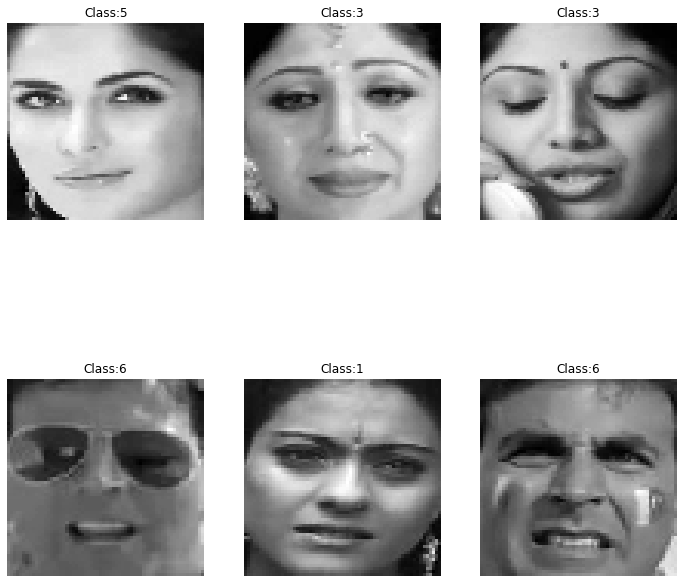

In [6]:
# Show sample images
ind = np.random.randint(0,y.shape[0],6)
disply_images(X[ind,...],y[ind], row=2,col=3)

# Features
    You are provided 6 Features. These features are:
   - Eigen Faces / PCA 
   - Kernel PCA
   - Fisher Face / LDA
   - Kernel Fisher Face
   - VGG Features 
   - Resnet Features

**VGG and Resnet features are last layer features learned by training a model for image classification**
    
---


In [7]:
# Flatten to apply PCA/LDA
og = X.copy()
X = X.reshape((N,H*W*C))
X.shape

(400, 4096)

###  1. Eigen Face:
Use principal component analysis to get the eigen faces. 
Go through the [documentation](!http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) on how to use it

In [8]:
def get_pca(X,k):
    """
        Get PCA of K dimension using the top eigen vectors 
    """
    pca = PCA(n_components=k)
    X_k = pca.fit_transform(X)
    return X_k

###  2. Kernel Face:
Use Kernel principal component analysis to get the eigen faces. 

There are different kernels that can be used. Eg. Poly, rbf, sigmoid. Choose the whichever gives the best result or representation. See [link](!https://data-flair.training/blogs/svm-kernel-functions/) for better understanding of these kernels  

Go through the [documentation](!https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.KernelPCA.html#sklearn.decomposition.KernelPCA) on how to use it different kernels in Sklearn. 

In [9]:
def get_kernel_pca(X, k,kernel='rbf', degree=3):
    """
        Get PCA of K dimension using the top eigen vectors 
        @param: X => Your data flattened to D dimension
        @param: k => Number of components
        @param: kernel => which kernel to use (“linear” | “poly” | “rbf” | “sigmoid” | “cosine” )
        @param: d => Degree for poly kernels. Ignored by other kernels
    """
    kpca = KernelPCA(n_components=k,kernel=kernel,degree=degree)
    X_k = kpca.fit_transform(X)
    return X_k

### 3. Fisher Face
Another method similar to the eigenface technique is `fisherfaces` which uses linear discriminant analysis.
This method for facial recognition is less sensitive to variation in lighting and pose of the face than using eigenfaces. Fisherface uses labelled data to retain more of the class-specific information during the dimension reduction stage.

Go through the [documentation](!https://scikit-learn.org/stable/modules/generated/sklearn.discriminant_analysis.LinearDiscriminantAnalysis.html) on how to use it different kernels in Sklearn. 

In [10]:
def get_lda(X,y, k):
    """
        Get LDA of K dimension 
        @param: X => Your data flattened to D dimension
        @param: k => Number of components
    """
    lda = LDA(n_components=k)
    X_k = lda.fit_transform(X,y)
    return X_k

### 4. Kernel Fisher Face
Use LDA using different kernels similiar to KernelPCA. Here the input is directly transformed instead of using the kernel trick.  

In [11]:
def get_kernel_lda(X,y,k,kernel='rbf',degree=3):
    """
        Get LDA of K dimension 
        @param: X => Your data flattened to D dimension
        @param: k => Number of components
        @param: kernel => which kernel to use ( “poly” | “rbf” | “sigmoid”)
    """
    # Transform  input
    if kernel == "poly":
        X_transformed = X**degree
    elif kernel == "rbf":
        var = np.var(X)
        X_transformed= np.exp(-X/(2*var))
    elif kernel == "sigmoid":
        X_transformed = np.tanh(X)
    else: 
        raise NotImplementedError("Kernel {} Not defined".format(kernel))
        
    klda = LDA(n_components=k)
    X_k = klda.fit_transform(X,y)
    return X_k

### 5. VGG Features
VGG Neural Networks a 19 layer CNN architecture introduced by Andrew Zisserman([Link](!https://arxiv.org/pdf/1409.1556.pdf) to paper). We are providing you with the last fully connected layer of this model.

The model was trained for face classification on each dataset and each feature the dimension of 4096.

In [12]:
def get_vgg_features(dirpath):
    features = np.load(os.path.join(dirpath,"VGG19_features.npy"))
    return features

### 6. Resnet Features

[Residual neural networks](!https://arxiv.org/pdf/1512.03385.pdf) are CNN with large depth, to effectively train these netwrorks they utilize skip connections, or short-cuts to jump over some layers. This helps solving [vanishing gradient problem](!https://en.wikipedia.org/wiki/Vanishing_gradient_problem) 

A 50 layer resnet model was trained for face classification on each dataset. Each feature the dimension of 2048

In [13]:
def get_resnet_features(dirpath):
    features = np.load(os.path.join(dirpath,"resnet50_features.npy"))
    return features

# Questions

1(a). What are eigen faces? 

___________________________
- Eigenfaces is the name given to a set of eigenvectors when they are used in the computer vision problem of 
    human face recognition.
    The eigenfaces themselves form a basis set of all images used to construct the covariance matrix. 
    This produces dimension reduction by allowing the smaller set of basis images to represent the original training 
    images. Classification can be achieved by comparing how faces are represented by the basis set. 

- Eigenfaces is a method that is useful for face recognition and detection by determining the variance of faces in a collection of face images and use those variances to encode and decode a face in a machine learning way without the full information reducing computation and space complexity.

- Select the hyperplane such that when all the points (conceptualize our m x n images as points in m n-dimensional space) are projected onto it, they are maximally spread out. In other words, we want the axis of maximal variance. Project our points onto this axis, they would be maximally spread




1(b).  How many eigen vectors/faces are required to “satisfactorily” reconstruct a  person  in  these  three  datasets? (Don’t  forget  to make your argument based on eigen value spectrum) Show appropriate graphs, qualitative examples and make a convincing argument.

In [14]:
# Compute your features 
# eg
# TO get best variance:
def pc(k, k_sum):
    eig = 0
    for eig in range(len(k)):
        pca_k = k[0:eig]
        pca_ksum = np.sum(pca_k)

        variance_retained = (pca_ksum/k_sum) * 100
        if(variance_retained>95):
            return eig+1
# For Yale

print("Yale:")
dirpath = './dataset/Yale_face_database'
X1,y1 = load_data(dirpath)
N,H,W = X1.shape[0:3]
C = 1 if opt['is_grayscale'] else X1.shape[3]
og1 = X1.copy()
X1 = X1.reshape((N,H*W*C))

pca = PCA(n_components=len(y1))
X_3D = pca.fit_transform(X1, y1)
eig_vals = np.asarray(pca.explained_variance_) 
eig_vals_Sum = np.sum(eig_vals.real)
eig_vecs = (pca.components_)

a = np.asarray(pca.explained_variance_ratio_)
req_pc = (np.cumsum(a)<=0.95).argmin()
# req_pc = pc(eig_vals, eig_vals_Sum)
print(req_pc)
pca1 = PCA(n_components=req_pc)
X_3D_1 = pca1.fit_transform(X1,y1)

# For IMFDB:
print("\nIMFDB:")
pca = PCA(n_components=len(y))
X_3D = pca.fit_transform(X, y)
eig_vals = np.asarray(pca.explained_variance_) 
eig_vals_Sum = np.sum(eig_vals.real)
eig_vecs = (pca.components_)

# req_pc = pc(eig_vals, eig_vals_Sum)

a = np.asarray(pca.explained_variance_ratio_)
req_pc = (np.cumsum(a)<=0.95).argmin()
print(req_pc)
pca = PCA(n_components=req_pc)
X_3D_2 = pca.fit_transform(X,y)


# For Cartoon
print("\nCartoon:")
dirpath = './dataset/IIIT-CFW'
X3,y3 = load_data(dirpath)
N,H,W = X3.shape[0:3]
C = 1 if opt['is_grayscale'] else X3.shape[3]
og3 = X3.copy()
X3 = X3.reshape((N,H*W*C))

pca3 = PCA(n_components=len(y3))
X_3D = pca3.fit_transform(X3, y3)
eig_vals = np.asarray(pca3.explained_variance_) 
eig_vals_Sum = np.sum(eig_vals.real)
eig_vecs = (pca3.components_)

a = np.asarray(pca3.explained_variance_ratio_)
req_pc = (np.cumsum(a)<=0.95).argmin()
# req_pc = pc(eig_vals, eig_vals_Sum)
print(req_pc)
pca3 = PCA(n_components=req_pc)
X_3D_3 = pca3.fit_transform(X3,y3)

Yale:
Dataset shape: (165, 64, 64)
65

IMFDB:
113

Cartoon:
Dataset shape: (672, 64, 64)
349


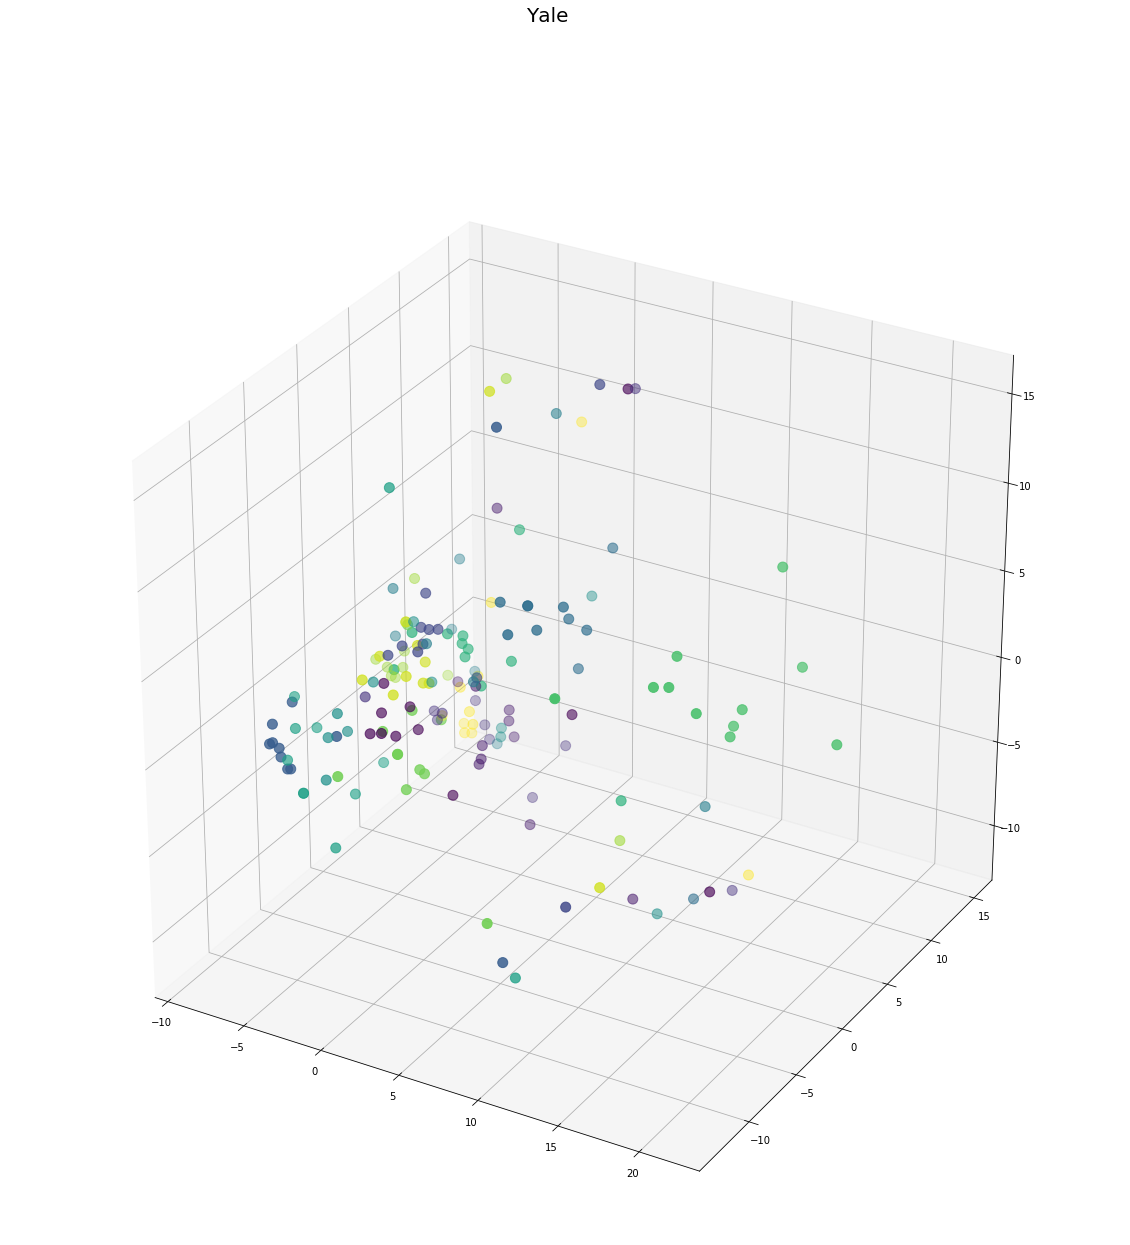

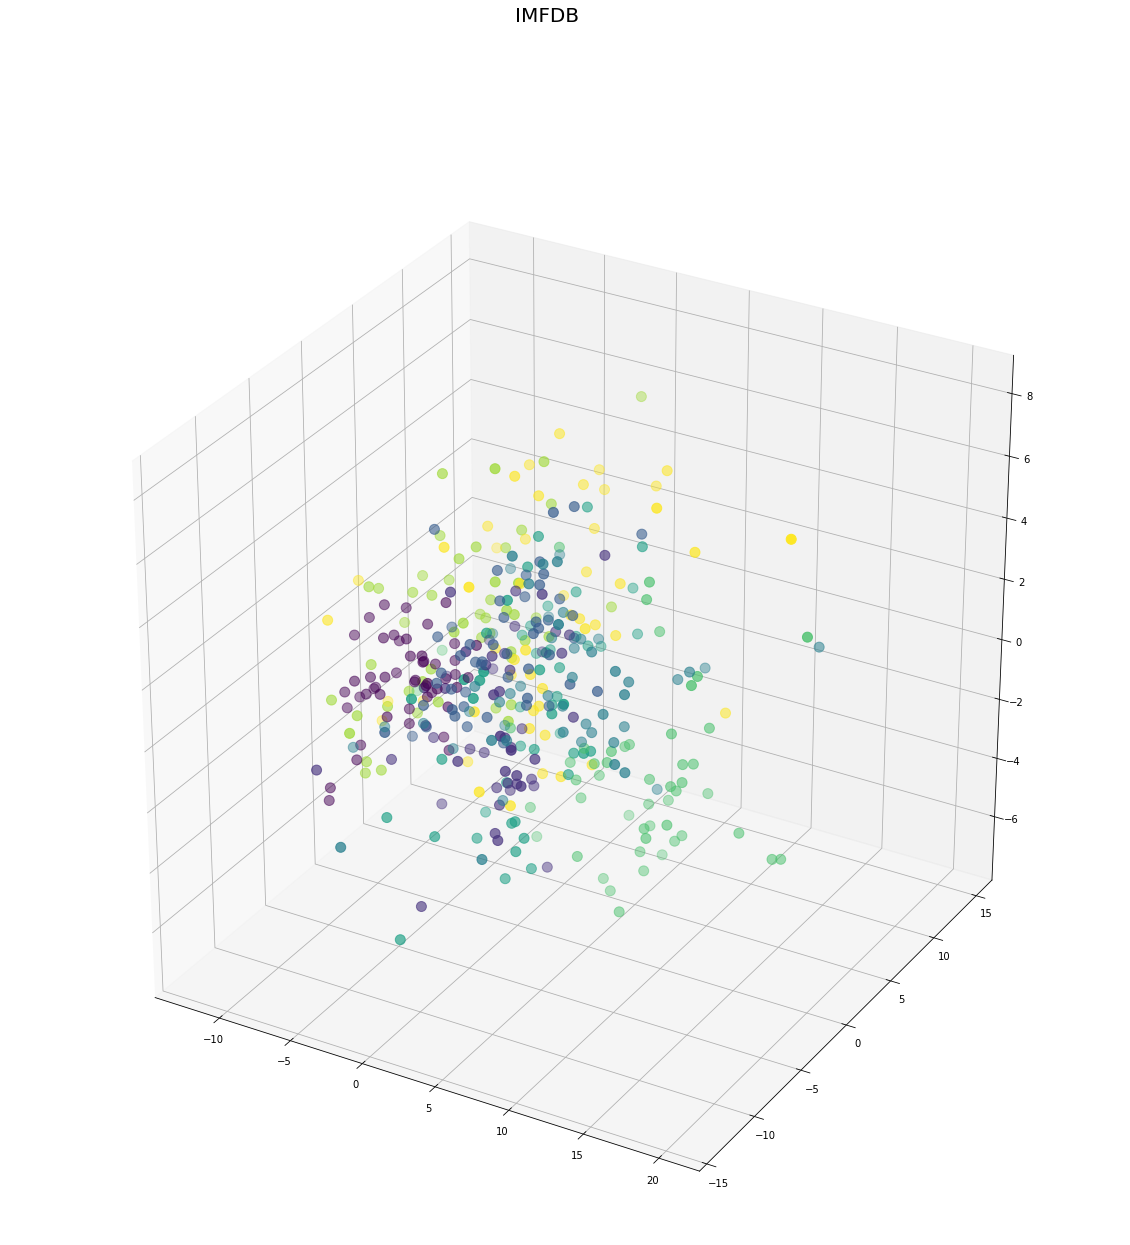

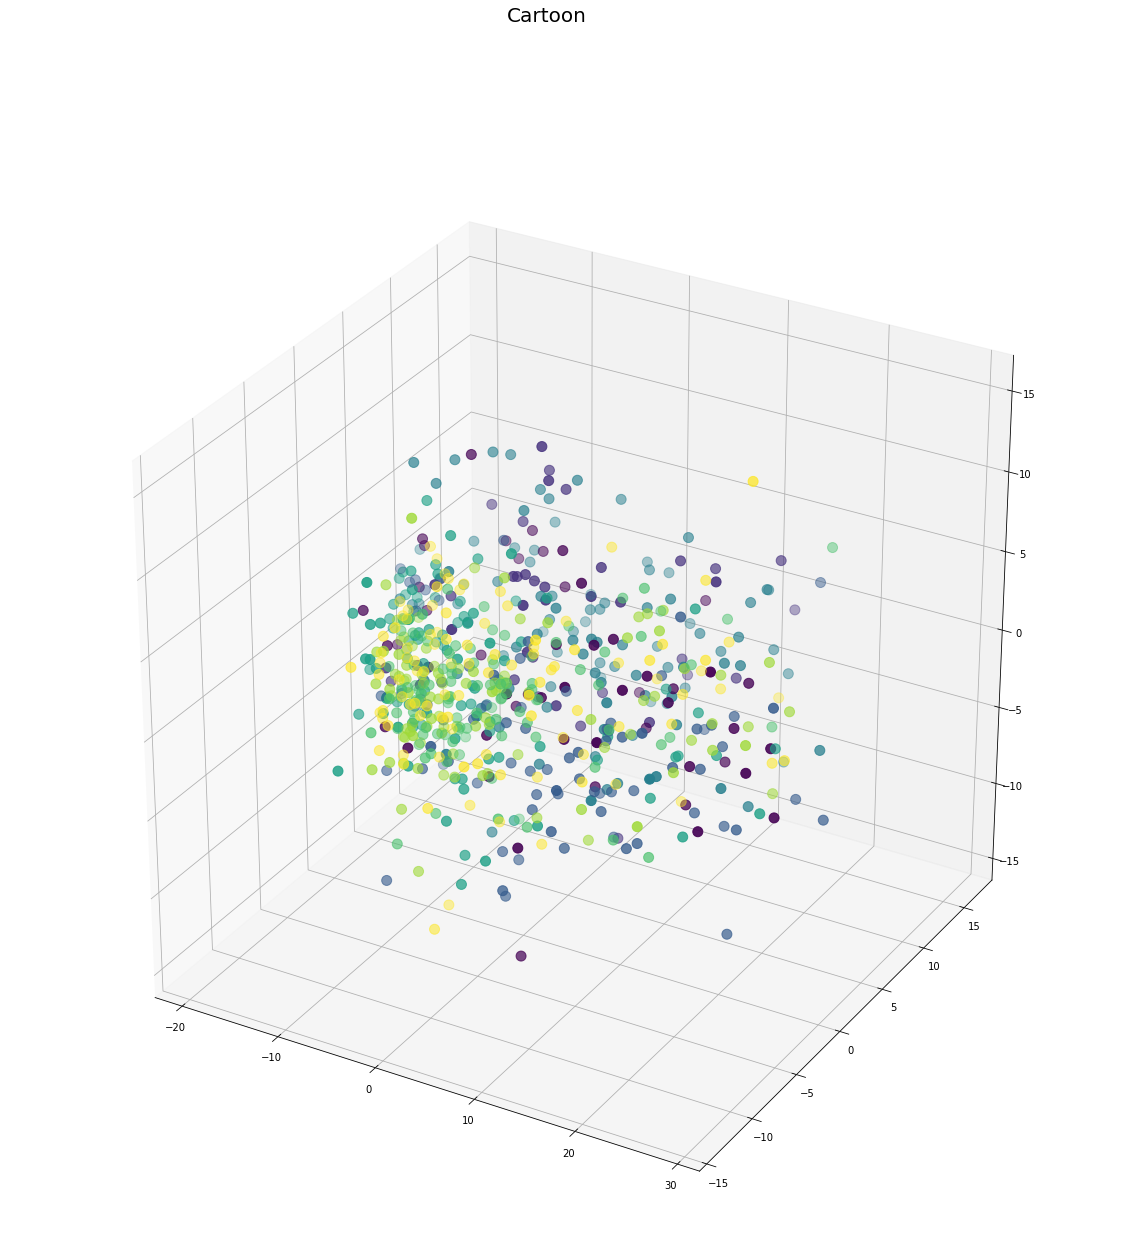

In [15]:
# Create a scatter plot  
# eg.
fig = plt.figure(figsize=(20,20))
fig.suptitle('Yale', fontsize=20)
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_3D_1[:,0],X_3D_1[:,1],X_3D_1[:,2],c=y1, s = 100)

fig = plt.figure(figsize=(20,20))
fig.suptitle('IMFDB', fontsize=20)
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_3D_2[:,0],X_3D_2[:,1],X_3D_2[:,2],c=y, s = 100)

fig = plt.figure(figsize=(20,20))
fig.suptitle('Cartoon', fontsize=20)
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_3D_3[:,0],X_3D_3[:,1],X_3D_3[:,2],c=y3, s = 100)

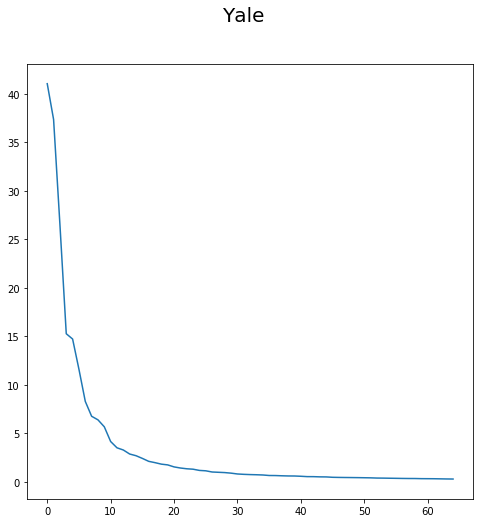

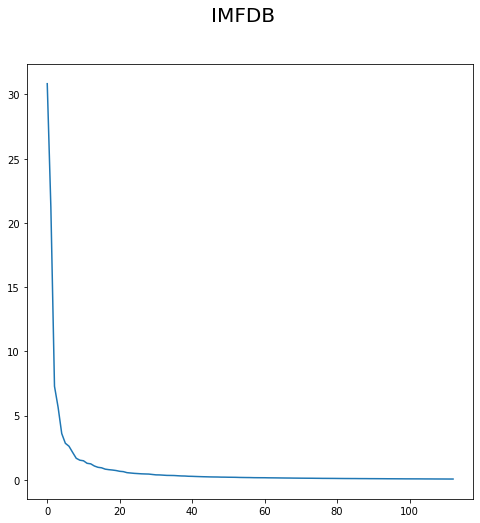

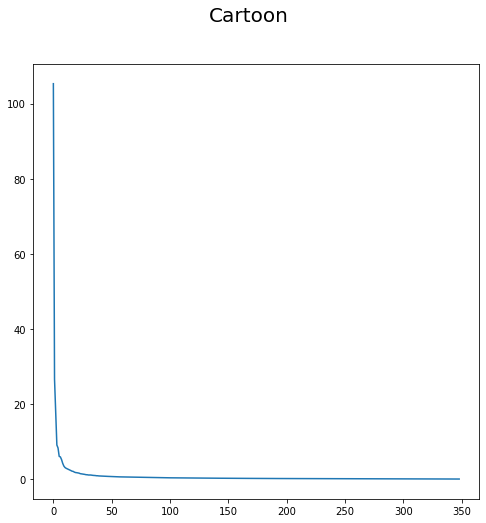

In [16]:
# Plot the eigen value spectrum
# pca = PCA(n_components=10)
# X_3D = pca.fit_transform(X.T, y)
eig_vals = np.asarray(pca1.explained_variance_) 
eig_vecs1 = (pca1.components_)
fig = plt.figure(figsize=(8,8))
fig.suptitle('Yale', fontsize=20)
ax = fig.add_subplot(111)
ax = plt.plot(np.arange(len(eig_vals)), eig_vals)

eig_vals = np.asarray(pca.explained_variance_) 
eig_vecs = (pca.components_)
fig = plt.figure(figsize=(8,8))
fig.suptitle('IMFDB', fontsize=20)
ax = fig.add_subplot(111)
ax = plt.plot(np.arange(len(eig_vals)), eig_vals)

eig_vals = np.asarray(pca3.explained_variance_) 
eig_vecs3 = (pca3.components_)
fig = plt.figure(figsize=(8,8))
fig.suptitle('Cartoon', fontsize=20)
ax = fig.add_subplot(111)
ax = plt.plot(np.arange(len(eig_vals)), eig_vals)

1(c). Reconstruct  the  image  back for each case


In [17]:
def reconstruct_images(X_3D, eig_vecs, *args,**kwargs):
    """
        Reconstruct the images back by just using the selected principal components. 


        You have to write the code in this code block.
        You can change the functions provided above (eg, get_pca, get_lda) for your use case. 
            
        @params: 
                Input parameters

        @return reconstructed_X => reconstructed image
        
    """
    
    reconstruct_X = X_3D.dot(eig_vecs)
    return reconstruct_X

Yale:


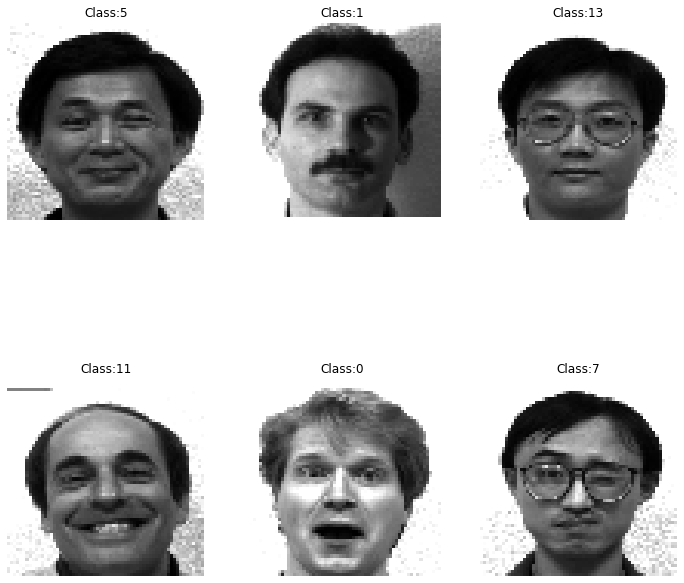

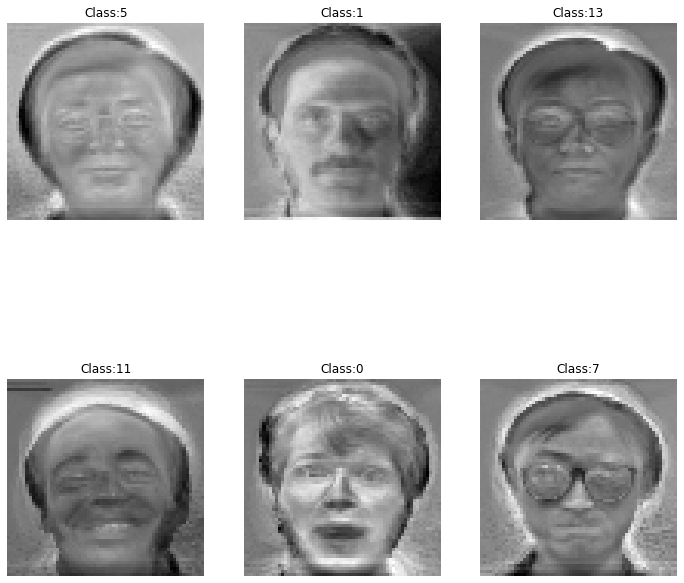

0.5989776150299345
IMFDB:


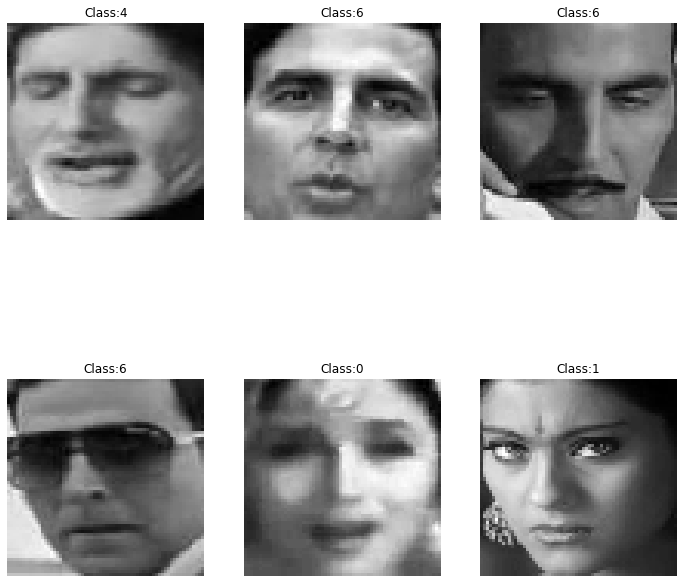

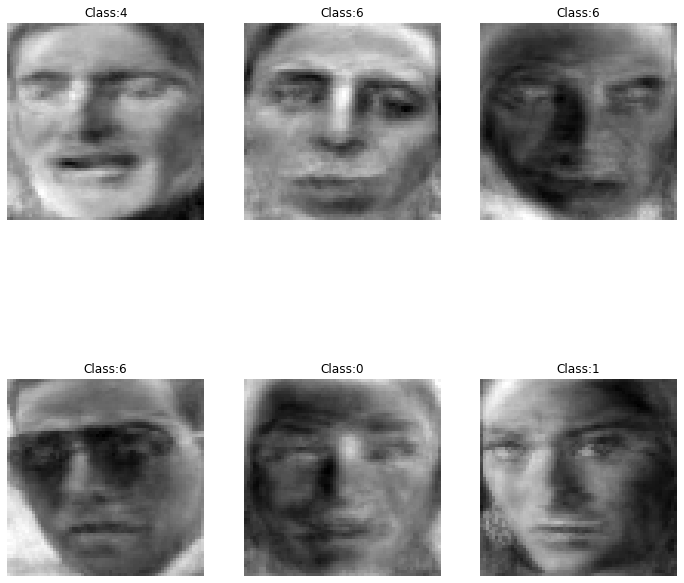

0.3966315303034731
Cartoon:


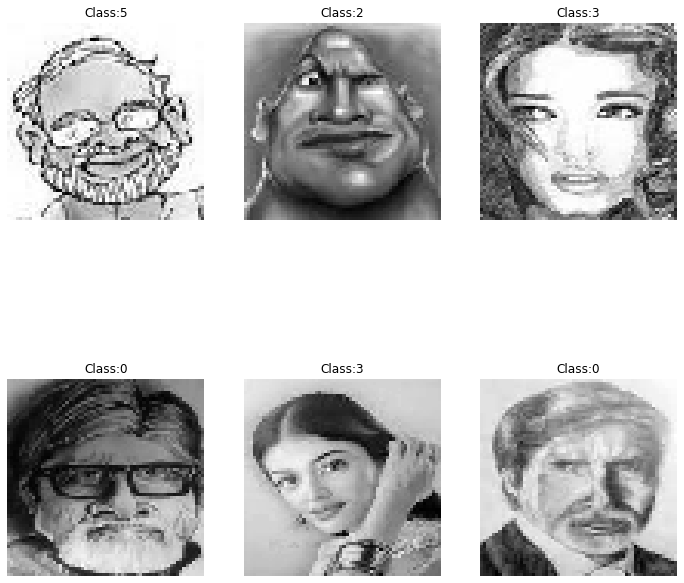

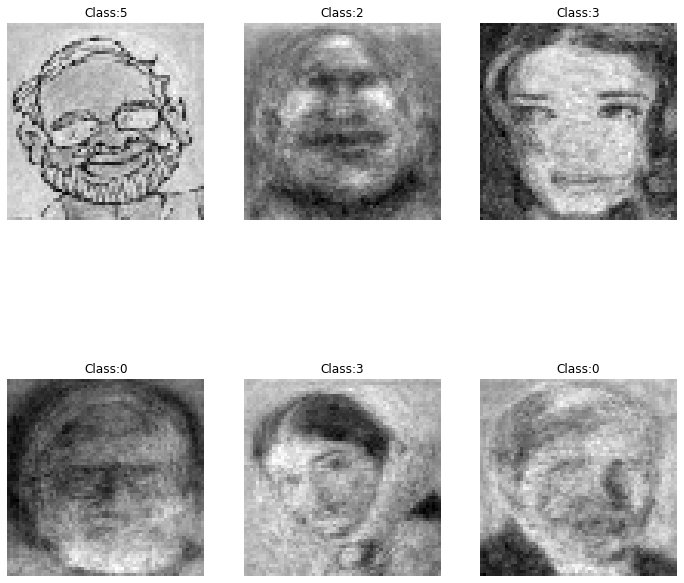

0.6403653681349297


In [18]:
# Display results 
print("Yale:")
X_reconstructed_1 = reconstruct_images(X_3D_1, eig_vecs1)

reconstruct_img_1 = np.reshape(X_reconstructed_1, (og1.shape[0],og1.shape[1], og1.shape[2]))
# Display random images
ind = np.random.randint(0,y1.shape[0],6)
disply_images(og1[ind,...],y1[ind], row=2,col=3)
disply_images(reconstruct_img_1[ind,...],y1[ind],row=2,col=3)

# Show the reconstruction error
print(np.sqrt(np.mean((X1 - X_reconstructed_1)**2)))

print("IMFDB:")
X_reconstructed = reconstruct_images(X_3D_2, eig_vecs)

reconstruct_img = np.reshape(X_reconstructed, (og.shape[0],og.shape[1], og.shape[2]))
# Display random images
ind = np.random.randint(0,y.shape[0],6)
disply_images(og[ind,...],y[ind], row=2,col=3)
disply_images(reconstruct_img[ind,...],y[ind],row=2,col=3)

# Show the reconstruction error
print(np.sqrt(np.mean((X - X_reconstructed)**2)))

print("Cartoon:")
X_reconstructed_3 = reconstruct_images(X_3D_3, eig_vecs3)

reconstruct_img_3 = np.reshape(X_reconstructed_3, (og3.shape[0],og3.shape[1], og3.shape[2]))
# Display random images
ind = np.random.randint(0,y3.shape[0],6)
disply_images(og3[ind,...],y3[ind], row=2,col=3)
disply_images(reconstruct_img_3[ind,...],y3[ind],row=2,col=3)

# Show the reconstruction error
print(np.sqrt(np.mean((X3 - X_reconstructed_3)**2)))



1(d). Which person/identity is difficult to represent com-pactly with fewer eigen vectors?  Why is that?  Explain with your empirical observations and intuitive answers

#### Yale Dataset
You can see that class 9 needs the highest number of eigen vectors for >95 variance and thus has the least amount of reconstruction loss. Minimizing reconstruction loss implies minimizing variance.

0
Class  0 :  4 eigen vectors
Class  1 :  5 eigen vectors
Class  2 :  5 eigen vectors
Class  3 :  4 eigen vectors
Class  4 :  3 eigen vectors
Class  5 :  4 eigen vectors
Class  6 :  5 eigen vectors
Class  7 :  5 eigen vectors
Class  8 :  5 eigen vectors
Class  9 :  5 eigen vectors
Class  10 :  6 eigen vectors
Class  11 :  5 eigen vectors
Class  12 :  5 eigen vectors
Class  13 :  4 eigen vectors
Class  14 :  5 eigen vectors

Reconstruction errors: Class with highest to lowest
[ 0 12  3 14  6  1 13  4  5 10  7  9  8 11  2]


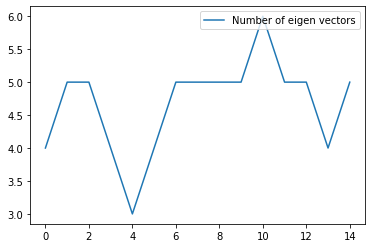

In [22]:
class_list = [[], [], [], [], [], [], [], [], [], [], [], [], [], [], []]
reconstruc_list = [[], [], [], [], [], [], [], [], [], [], [], [], [], [], []]
for i in range(len(y1)):
    i_class = int(y1[i])
    class_list[i_class].append(X1[i])
    reconstruc_list[i_class].append(X_reconstructed_1[i])

class_list = np.asarray(class_list)
errors = list()
for i in range(15):
    errors.append(np.sqrt(np.mean((np.array(class_list[i]) - np.array(reconstruc_list[i]))**2)))

print(np.argmax(np.asarray(errors)))

eig1 = []
for i in range(len(class_list)): #there
    pca = PCA(n_components=len(class_list[i]))
    pca.fit(class_list[i])
    a = np.asarray(pca.explained_variance_ratio_)
    print("Class ",i , ": ", (np.cumsum(a)<=0.90).argmin(), "eigen vectors")
    eig1.append((np.cumsum(a)<=0.90).argmin())
    
print("\nReconstruction errors: Class with highest to lowest")
print((-np.asarray(errors)).argsort())

def normalize(v):
    norm = np.linalg.norm(v)
    if norm == 0: 
       return v
    return v / norm
plt.plot(np.arange(len(errors)), eig1, label = "Number of eigen vectors")
# plt.plot(np.arange(len(errors)), errors, label = "Reconstruction Error")
plt.legend(loc="upper right")

### IMFDB
#### In this way, you can see the classes which require most number of eigen vectors to reconstruct for a 64 x 64 grayscale image.
- From the graph below, it is apparent that Madhuri Dixit (Class 0) needs highest number of eigen vectors to reconstruct. 
- Moreover we know that maximizing variance implies minimizing reconstruction error and from the results proved below we can see that by taking a high number of components while performing PCA on the entire dataset, we essentially reduce the reconstruction error for Class 0.

- Minimum Eigen vectors needed by Katrina Kaif.

Class  0 :  27 eigen vectors
Class  1 :  21 eigen vectors
Class  2 :  24 eigen vectors
Class  3 :  20 eigen vectors
Class  4 :  21 eigen vectors
Class  5 :  17 eigen vectors
Class  6 :  22 eigen vectors
Class  7 :  20 eigen vectors

Reconstruction errors sorted by index:
[2 6 1 4 3 5 7 0]


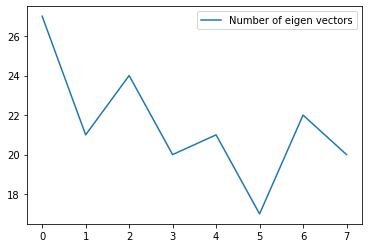

In [24]:
# code goes here
class_list = [[], [], [], [], [], [], [], []]
reconstruc_list = [[], [], [], [], [], [], [], []]
for i in range(400):
    i_class = int(y[i])
    class_list[i_class].append(X[i])
    reconstruc_list[i_class].append(X_reconstructed[i])

class_list = np.asarray(class_list)
errors = list()
for i in range(8):
    errors.append(np.sqrt(np.mean((np.array(class_list[i]) - np.array(reconstruc_list[i]))**2)))

# print(np.argmax(np.asarray(errors)))


eig2 = []
for i in range(len(class_list)): #there
    pca = PCA(n_components=len(class_list[i]))
    pca.fit(class_list[i])
    a = np.asarray(pca.explained_variance_ratio_)
    print("Class ",i , ": ", (np.cumsum(a)<=0.90).argmin(), "eigen vectors")
    eig2.append((np.cumsum(a)<=0.90).argmin())

print("\nReconstruction errors sorted by index:")
print((-np.asarray(errors)).argsort())

def normalize(v):
    norm = np.linalg.norm(v)
    if norm == 0: 
       return v
    return v / norm
plt.plot(np.arange(len(errors)), eig2, label = "Number of eigen vectors")
# plt.plot(np.arange(len(errors)), errors, label = "Reconstruction Error")
plt.legend(loc="upper right")


### IIIT-Cartoon Dataset


Class  0 :  23 eigen vectors
Class  1 :  26 eigen vectors
Class  2 :  34 eigen vectors
Class  3 :  47 eigen vectors
Class  4 :  55 eigen vectors
Class  5 :  66 eigen vectors
Class  6 :  61 eigen vectors
Class  7 :  57 eigen vectors

Reconstruction errors:
[2 3 4 1 7 0 6 5]


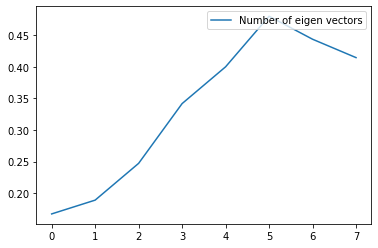

In [26]:
class_list = [[], [], [], [], [], [], [], []]
reconstruc_list = [[], [], [], [], [], [], [], []]
for i in range(len(y3)):
    i_class = int(y3[i])
    class_list[i_class].append(X3[i])
    reconstruc_list[i_class].append(X_reconstructed_3[i])

class_list = np.asarray(class_list)
errors = list()
for i in range(8):
    errors.append(np.sqrt(np.mean((np.array(class_list[i]) - np.array(reconstruc_list[i]))**2)))

eig3 = []
for i in range(len(class_list)): #there
    pca = PCA(n_components=len(class_list[i]))
    pca.fit(class_list[i])
    a = np.asarray(pca.explained_variance_ratio_)
    print("Class ",i , ": ", (np.cumsum(a)<=0.90).argmin(), "eigen vectors")
    eig3.append((np.cumsum(a)<=0.90).argmin())
    
def normalize(v):
    norm = np.linalg.norm(v)
    if norm == 0: 
       return v
    return v / norm
plt.plot(np.arange(len(errors)), normalize(eig3), label = "Number of eigen vectors")
# plt.plot(np.arange(len(errors)), errors, label = "Reconstruction Error")
plt.legend(loc="upper right")

print("\nReconstruction errors:")
print((-np.asarray(errors)).argsort())

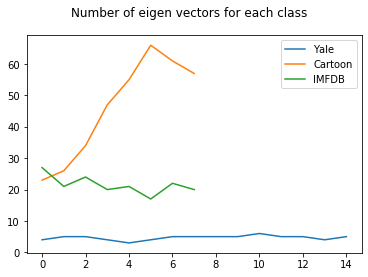

In [29]:
plt.suptitle("Number of eigen vectors for each class")
plt.plot(np.arange(15), eig1, label = "Yale")
plt.plot(np.arange(8), eig3, label = "Cartoon")
plt.plot(np.arange(8), eig2, label = "IMFDB")
# plt.plot(np.arange(len(errors)), errors, label = "Reconstruction Error")
plt.legend(loc="upper right")

## Question 2
2(a). Use any classifier(MLP, Logistic regression, SVM, Decision Trees) and find the classification accuracy. 

2(b)Which method works well? Do a comparitivestudy. 


You already know the paper [Face Recognition Us-ing  Kernel  Methods](!http://face-rec.org/algorithms/Kernel/nips01.pdf) .See  this  as  an  example for empirical analysis of different features/classification.

In [30]:
# Define your classifier here. You can use libraries like sklearn to create your classifier 
from sklearn.datasets import fetch_lfw_people
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, precision_recall_curve, f1_score, precision_recall_fscore_support
# from sklearn.decomposition import RandomizedPCA
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn import tree

from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from IPython.display import display

class Classifier():
    def __init__(self):
        super(self.__class__, self).__init__()
        self.epochs = 3
        self.learning_rate = 0.00001
        self.batch_size = 5
        self.max_iterations = 4000
        self.clf = SVC(kernel='linear', C=3, max_iter=self.max_iterations, gamma = 0.1)
            
    # Define your parameters eg, W,b, max_iterations etc. 
    
    def classify(self,X):
        """
            Given an input X classify it into appropriate class. 
        """
        # scaler = StandardScaler()
        # X = scaler.fit_transform(X)
        prediction = self.clf.predict(X)
        
        return prediction
        
    def confusion_matrix(self,pred,y):
        """
            A confusion matrix is a table that is often used to describe the performance of a classification
            model (or “classifier”) on a set of test data for which the true values are known.
            
            
            @return confusion_matrix => num_classesxnum_classes martix 
                where confusion_matrix[i,j] = number of prediction which are i and number of ground truth value equal j 
        
        """

        conf_mat = confusion_matrix(pred, y)

        conf = pd.DataFrame(data=conf_mat)
        conf.columns.name = 'Predicted'
        conf.index.name = 'Actual'

        return conf_mat, conf
        
    def train(self,X_train,y_train, types):
        """
            Given your training data, learn the parameters of your classifier
            
            @param X_train => NxD tensor. Where N is the number of samples and D is the dimension. 
                                it is the data on which your classifier will be trained. 
                                It can be any combination of features provided above.

            @param y_train => N vector. Ground truth label 
    
            @return Nothing
        """
        # scaler = StandardScaler()
        # X_train = scaler.fit_transform(X_train)
        if types=='MLP':
            self.clf = MLPClassifier(hidden_layer_sizes=(200,50),max_iter=self.max_iterations)
            self.clf.fit(X_train, y_train)
        elif types=='LR':
            self.clf = LogisticRegression(random_state=0, solver='lbfgs', multi_class = 'ovr', max_iter=self.max_iterations)
            self.clf.fit(X_train, y_train)
            # self.clf=LogisticRegression(random_state=0, solver='lbfgs',multi_class='multinomial')
        elif types=='SVM':
            self.clf = SVC(kernel='linear', C=3, max_iter=self.max_iterations, gamma = 0.1)
            self.clf.fit(X_train, y_train)
        elif types=='DT':
            self.clf = tree.DecisionTreeClassifier()
            self.clf.fit(X_train,y_train)
        
    def validate(self,X_validate,y_validate, flag=True):
        """
            How good is the classifier on unseen data? Use the function below to calculate different metrics. 
            Based on these matrix change the hyperparmeters and judge the classification
            
            @param X_validate => NxD tensor. Where N is the number of samples and D is the dimension. 
                                it is the data on which your classifier validated. 
                                It can be any combination of features provided above.

            @param y_validate => N vector. Ground truth label 
            
        """

        # Create a confusion matrix
        pred = self.classify(X_validate)
        conf_mat, pdframe = self.confusion_matrix(pred, y_validate)
        accuracy = self.clf.score(X_validate, y_validate) * 100
        # y_score = self.clf.decision_function(X_validate)
        metrics = precision_recall_fscore_support(y_validate, pred, average='macro', labels=np.unique(pred))
        f1score = metrics[2]*100

        if flag:
            display(pdframe)
            print("--------------------------------------------")
            # Calculate Validation accuracy 
            
            print("Accuracy = {0:0.2f}%".format(accuracy))
        
            # Calculate precision and recall 
            print("Precision = {0:0.2f}".format(metrics[0]*100))
            print("Recall = {0:0.2f}".format(metrics[1]*100))
            #?????????
            # Calculate F1-score
            
            print("F1 Score = {0:0.2f}".format(metrics[2]*100))
    
        return accuracy, f1score, pdframe

In [31]:
# Create a train and validation split to train your classifier 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
model = Classifier()
model.train(X_train, y_train, 'LR')
acc, f1, conf = model.validate(X_test, y_test)

Predicted,0,1,2,3,4,5,6,7
Actual,,,,,,,,
0,11,1,0,0,1,1,3,2
1,0,4,0,2,1,1,0,0
2,1,2,8,0,0,0,0,0
3,0,0,0,9,0,0,1,0
4,0,0,0,0,11,0,0,1
5,0,0,0,2,0,9,0,0
6,0,0,0,0,0,1,11,2
7,0,1,0,2,0,1,0,11


--------------------------------------------
Accuracy = 74.00%
Precision = 74.50
Recall = 74.70
F1 Score = 73.38


In [32]:
# Create 3 tables simiar to page-6 of the paper. One table per dataset 
# Each table will have 5 columns. 
# Feature/combination of feature used, reduced dimension space, classification error, accuracy, f1-score
import pandas as pd
import warnings

warnings.filterwarnings(action='ignore')
columns=['Method','Reduced Dim','Classification Error','Accuracy','F1 Score']
index=['1','2','3','4','5', '6','7','8', '9','10']
data = []

datasets = ["./dataset/Yale_face_database","./dataset/IMFDB","./dataset/IIIT-CFW"]
num_class = [15,8,8]
best = []
best_conf = []
for k in range(len(datasets)):
    Xdash, ydash = load_data(datasets[k])
    N,H,W = Xdash.shape[0:3]
    C = 1 if opt['is_grayscale'] else Xdash.shape[3]
    # og = Xdash.copy()
    Xdash = Xdash.reshape((N,H*W*C))
    X_train, X_test, y_train, y_test = train_test_split(Xdash, ydash, test_size=0.25, random_state=42)
    metrics = []
    confs = []
    model = Classifier()
    model.train(X_train, y_train, 'MLP')
    acc, _, c1= model.validate(X_test, y_test, False)
    metrics.append(acc)
    confs.append(c1)

    model.train(X_train, y_train, 'LR')
    acc, _, c1= model.validate(X_test, y_test, False)
    metrics.append(acc)
    confs.append(c1)

    model.train(X_train, y_train, 'SVM')
    acc, _, c1 = model.validate(X_test, y_test, False)
    metrics.append(acc)
    confs.append(c1)

    model.train(X_train, y_train, 'DT')
    acc, _, c1 = model.validate(X_test, y_test, False)
    metrics.append(acc)
    confs.append(c1)

    best.append(np.argmax(metrics))
    best_conf.append(confs[best[k]])


    feat=get_resnet_features(datasets[k])

    X_train, X_test, y_train, y_test = train_test_split(feat, ydash, test_size=0.25, random_state=42)

    model = Classifier()
    model.train(X_train, y_train, 'MLP')
    acc, fscore, _ = model.validate(X_test, y_test, False)
    data.append(['Resnet + MLP',feat.shape[1], 100 - acc, acc, fscore])

    model.train(X_train, y_train, 'LR')
    acc, fscore, _ = model.validate(X_test, y_test, False)
    data.append(['Resnet + LR',feat.shape[1], 100 - acc, acc, fscore])

    model.train(X_train, y_train, 'SVM')
    acc, fscore, _ = model.validate(X_test, y_test, False)
    data.append(['Resnet + SVM',feat.shape[1], 100 - acc, acc, fscore])


    feat=get_resnet_features(datasets[k])
    feat=get_lda(feat, ydash, 7)

    X_train, X_test, y_train, y_test = train_test_split(feat, ydash, test_size=0.25, random_state=42)

    model = Classifier()
    model.train(X_train, y_train, 'MLP')
    acc, fscore, _ = model.validate(X_test, y_test, False)
    data.append(['Resnet + LDA + MLP',feat.shape[1], 100 - acc, acc, fscore])

    model.train(X_train, y_train, 'LR')
    acc, fscore, _ = model.validate(X_test, y_test, False)
    data.append(['Resnet + LDA + LR',feat.shape[1], 100 - acc, acc, fscore])

    feat = get_pca(Xdash, 100)
    X_train, X_test, y_train, y_test = train_test_split(feat, ydash, test_size=0.25, random_state=42)
   
    model.train(X_train, y_train, 'MLP')
    acc, fscore, _ = model.validate(X_test, y_test, False)
    data.append(['PCA + MLP',feat.shape[1], 100 - acc, acc, fscore])

    model.train(X_train, y_train, 'SVM')
    acc, fscore, _ = model.validate(X_test, y_test, False)
    data.append(['PCA + SVM',feat.shape[1], 100 - acc, acc, fscore])

    feat=get_resnet_features(datasets[k])
    feat=get_kernel_lda(feat, ydash, 7)

    X_train, X_test, y_train, y_test = train_test_split(feat, ydash, test_size=0.25, random_state=42)

    model = Classifier()
    model.train(X_train, y_train, 'MLP')
    acc, fscore, _ = model.validate(X_test, y_test, False)
    data.append(['Resnet + rbf KernelLDA + MLP',feat.shape[1], 100 - acc, acc, fscore])

    feat=get_vgg_features(datasets[k])
    # feat=get_kernel_lda(feat, ydash, 7)

    X_train, X_test, y_train, y_test = train_test_split(feat, ydash, test_size=0.25, random_state=42)

    model = Classifier()
    model.train(X_train, y_train, 'LR')
    acc, fscore, _ = model.validate(X_test, y_test, False)
    data.append(['VGG + LR',feat.shape[1], 100 - acc, acc, fscore])

    model.train(X_train, y_train, 'LR')
    acc, fscore, _ = model.validate(X_test, y_test, False)
    data.append(['VGG + SVM',feat.shape[1], 100 - acc, acc, fscore])


best = np.asarray(best)
best_conf = np.asarray(best_conf)

df1 = pd.DataFrame(data[0:10],columns=columns, index=index)
print("\nTable for Yale_face_database")
display(df1)

# Print the table. (You can use Pandas)


Dataset shape: (165, 64, 64)
Dataset shape: (400, 64, 64)
Dataset shape: (672, 64, 64)

Table for Yale_face_database


,Method,Reduced Dim,Classification Error,Accuracy,F1 Score
1,Resnet + MLP,2048,0.000000,100.000000,100.000000
2,Resnet + LR,2048,2.380952,97.619048,96.444444
3,Resnet + SVM,2048,2.380952,97.619048,96.444444
4,Resnet + LDA + MLP,7,0.000000,100.000000,100.000000
5,Resnet + LDA + LR,7,0.000000,100.000000,100.000000
6,PCA + MLP,100,19.047619,80.952381,80.253968
7,PCA + SVM,100,11.904762,88.095238,87.195767
8,Resnet + rbf KernelLDA + MLP,7,0.000000,100.000000,100.000000
9,VGG + LR,4096,45.238095,54.761905,53.722944
10,VGG + SVM,4096,45.238095,54.761905,53.722944


In [33]:
df2 = pd.DataFrame(data[10:20],columns=columns, index=index)
print("\nTable for IMFDB")
display(df2)


Table for IMFDB


,Method,Reduced Dim,Classification Error,Accuracy,F1 Score
1,Resnet + MLP,2048,4.0,96.0,95.454343
2,Resnet + LR,2048,5.0,95.0,94.589579
3,Resnet + SVM,2048,6.0,94.0,93.964836
4,Resnet + LDA + MLP,7,0.0,100.0,100.000000
5,Resnet + LDA + LR,7,0.0,100.0,100.000000
6,PCA + MLP,100,35.0,65.0,64.819327
7,PCA + SVM,100,29.0,71.0,70.787246
8,Resnet + rbf KernelLDA + MLP,7,0.0,100.0,100.000000
9,VGG + LR,4096,8.0,92.0,92.489688
10,VGG + SVM,4096,8.0,92.0,92.489688


In [34]:
df3 = pd.DataFrame(data[20:30],columns=columns, index=index)
print("\nTable for IIIT-CFW")
display(df3)


Table for IIIT-CFW


,Method,Reduced Dim,Classification Error,Accuracy,F1 Score
1,Resnet + MLP,2048,2.380952,97.619048,97.396010
2,Resnet + LR,2048,2.380952,97.619048,97.395087
3,Resnet + SVM,2048,2.976190,97.023810,96.605312
4,Resnet + LDA + MLP,7,0.000000,100.000000,100.000000
5,Resnet + LDA + LR,7,0.000000,100.000000,100.000000
6,PCA + MLP,100,55.357143,44.642857,45.585992
7,PCA + SVM,100,60.119048,39.880952,39.177926
8,Resnet + rbf KernelLDA + MLP,7,0.000000,100.000000,100.000000
9,VGG + LR,4096,27.976190,72.023810,67.598383
10,VGG + SVM,4096,27.976190,72.023810,67.598383


### After trying variety of combination these were some of the diverse results found. Resnet with Kernel LDA and LDA yielded best results each time, while VGG, Decision Trees, PCA yielded considerably lower accuracies.
However seeing as PCA is unsupervised dimensional reduction, the results are not surprising.

In [35]:
# For each dataset print the confusion matrix for the best model 
import seaborn as sns
for i in range(0,3):
    if i==0:
        print("Yale_face_database:-")
    if i==1:
        print("\nIMFDB:-")
    if i==2:
        print("\nIIIT-CFW:-")
    if best[i]==0:
        print("The best Model is MLP")
    elif best[i]==1:
        print("The best Model is Logistic Regression")
    elif best[i]==2:
        print("The best Model is SVM")
    elif best[i]==3:
        print("The best Model is Decision-trees")
#     print("\n",best_conf[i])
 
    display(best_conf[i])

Yale_face_database:-
The best Model is MLP


Predicted,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
Actual,,,,,,,,,,,,,,,
0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,3,0,0,0,0,1,0,0,0,0,0,0,0,0
2,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,1,2,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,4,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,4,0,0,0,0,0,0



IMFDB:-
The best Model is Logistic Regression


Predicted,0,1,2,3,4,5,6,7
Actual,,,,,,,,
0,11,1,0,0,1,1,3,2
1,0,4,0,2,1,1,0,0
2,1,2,8,0,0,0,0,0
3,0,0,0,9,0,0,1,0
4,0,0,0,0,11,0,0,1
5,0,0,0,2,0,9,0,0
6,0,0,0,0,0,1,11,2
7,0,1,0,2,0,1,0,11



IIIT-CFW:-
The best Model is SVM


Predicted,0,1,2,3,4,5,6,7
Actual,,,,,,,,
0,8,2,1,4,3,0,1,0
1,1,4,1,2,1,0,2,0
2,0,0,5,1,2,0,4,4
3,2,3,3,21,1,4,0,4
4,1,1,3,1,11,2,1,3
5,0,1,2,0,1,9,2,6
6,0,0,4,2,1,2,8,0
7,0,0,3,2,1,3,0,14


## Question 3
3. Similiar to 1(b) use t-SNE based visilization of faces?  Does it makesense?  Do you see similar people coming together?or something else?  Can you do visualization datasetwise and combined? Here you will use a popular implementation.(Worth  reading and understanding  t-SNE.  We  will not discuss it in the class and out of scope for thiscourse/exams.

### TSNE
- Takes a set of points in a high-dimensional space and find a faithful representation of those points in a lower-dimensional space, typically the 2D plane.
- Tuneable parameter, “perplexity,” which deals with how to balance attention between local and global aspects of your data. Typical values are between 5 and 50.
- t-SNE algorithm adapts its notion of “distance” to regional density variations in the data set. As a result, it naturally expands dense clusters, and contracts sparse ones, evening out cluster sizes. Therefore two differently sized clusters look the same.

- Global geometry requires fine-tuning perplexity. Real-world data would probably have multiple clusters with different numbers of elements. Since perplexity is a global parameter, there may not be one perplexity value that will capture distances across all clusters. Therfore, distances between well-separated clusters in a t-SNE plot may mean nothing.

Yale


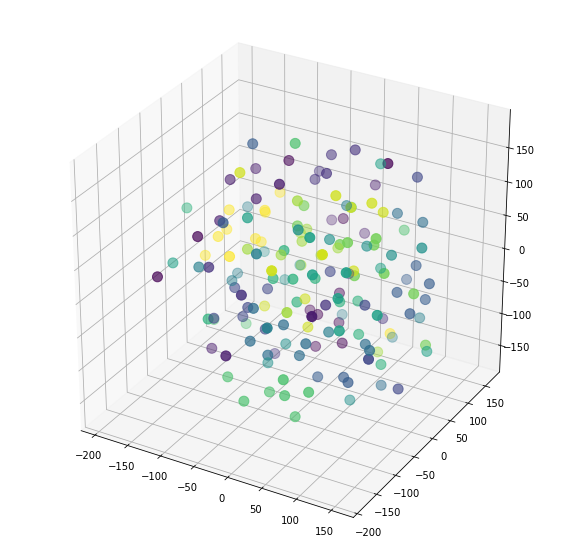

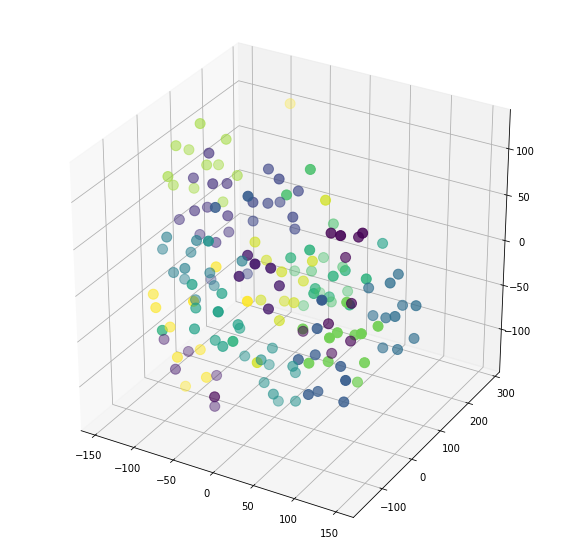

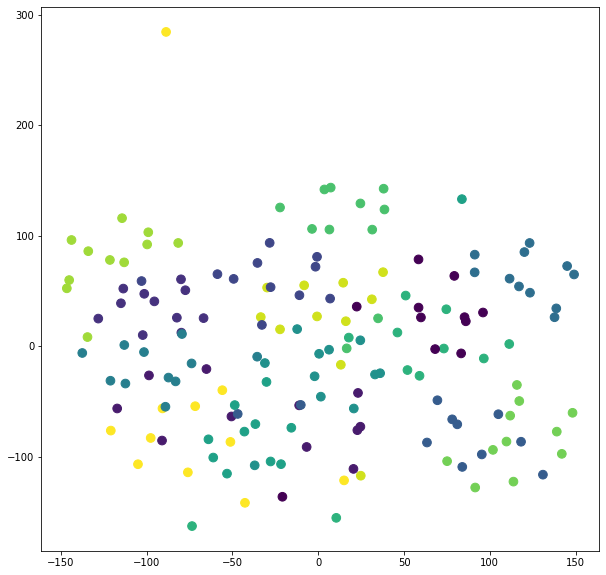

In [36]:
# Compute TSNE for different features and create a scatter plot
from sklearn.manifold import TSNE
import warnings
# X =  # feature 

def tsne(X,Y):
    k = 3 # Number of components in TSNE
    # Compute
    X_TSNE = TSNE(n_components=k).fit_transform(X)
    # print(X_TSNE.shape)
    lda_X = get_lda(X, Y, 3)
    X_tLDA = TSNE(n_components=k).fit_transform(lda_X)

    plt.figure(figsize=(10,10))
    ax = plt.axes(projection="3d")
    ax.scatter3D(X_TSNE[:,0],X_TSNE[:,1],X_TSNE[:,2],c=Y, s = 100)

    plt.figure(figsize=(10,10))
    ax = plt.axes(projection="3d")
    ax.scatter3D(X_tLDA[:,0],X_tLDA[:,1],X_tLDA[:,2],c=Y, s = 100)

    plt.figure(figsize=(10,10))
    plt.scatter(X_tLDA[:,0],X_tLDA[:,1],c=Y, s = 75)
    return X_tLDA

# Plot the representation in 2d/3d
print("Yale")
a = tsne(X1,y1)

# Compute
# X_TSNE = TSNE(n_components=k).fit_transform(X)


# Plot the representation in 2d/3d


IMFDB


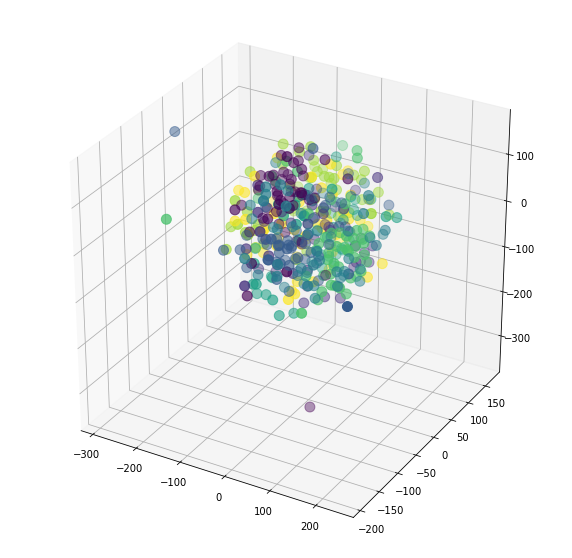

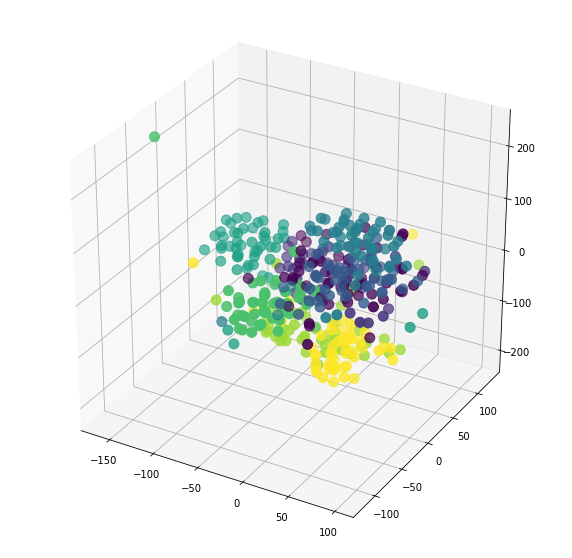

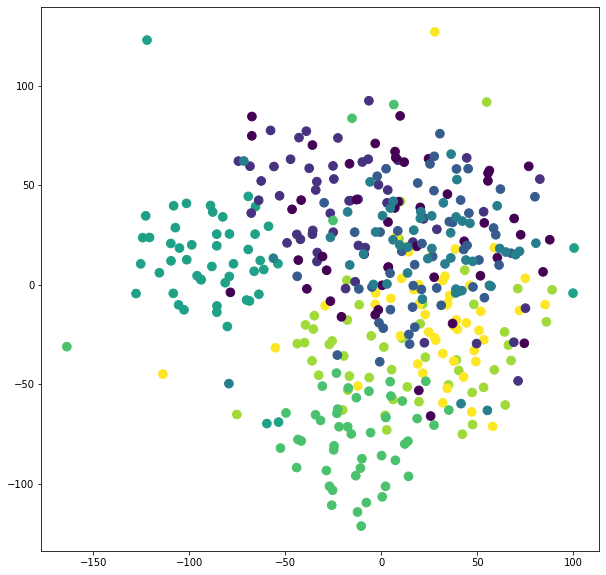

In [37]:
print("IMFDB")
b = tsne(X,y)

Cartoon


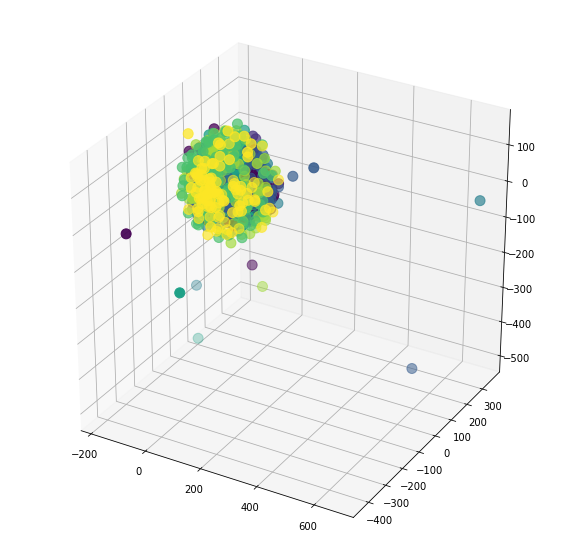

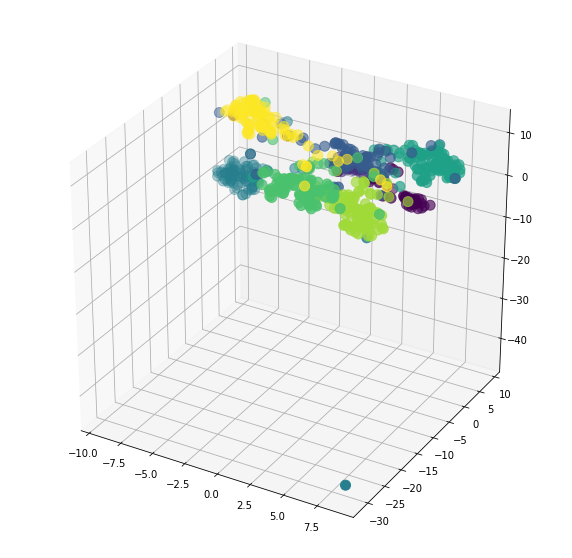

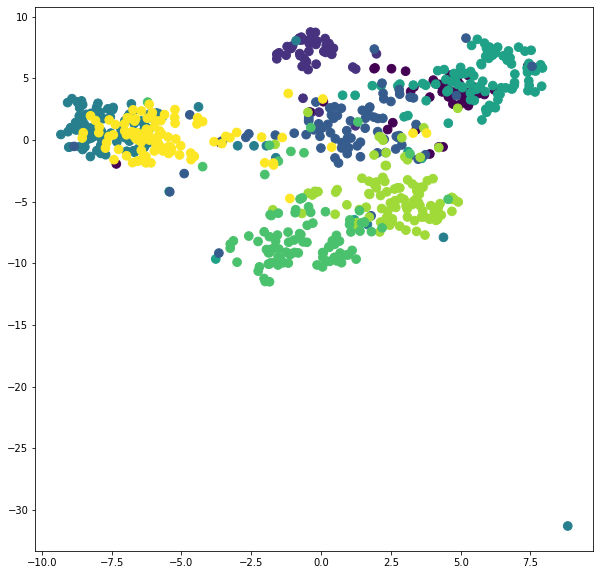

In [38]:
print("Cartoon")
c = tsne(X3,y3)

Combined Dataset
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]


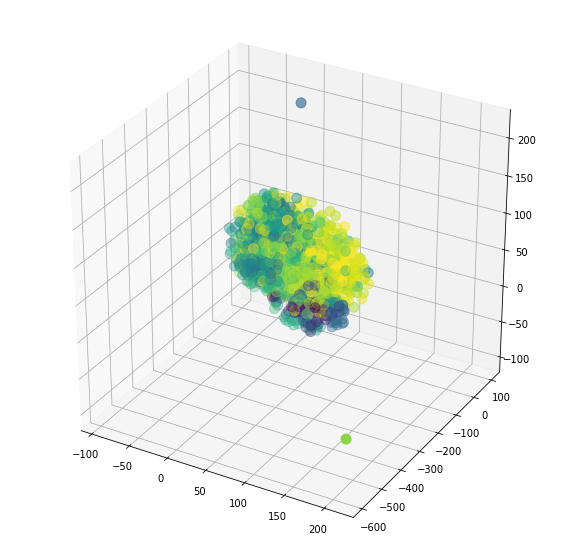

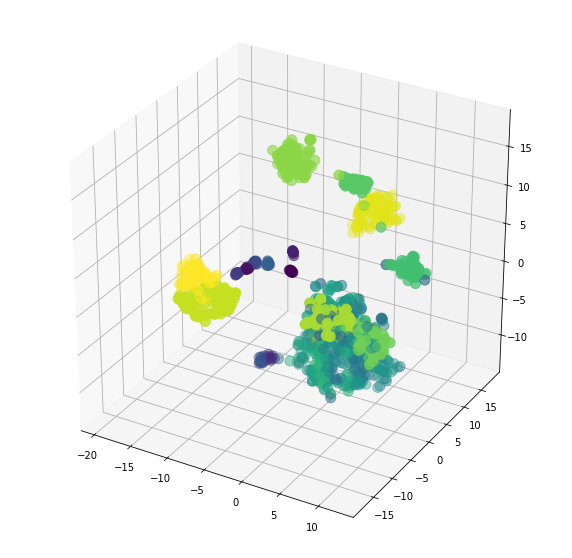

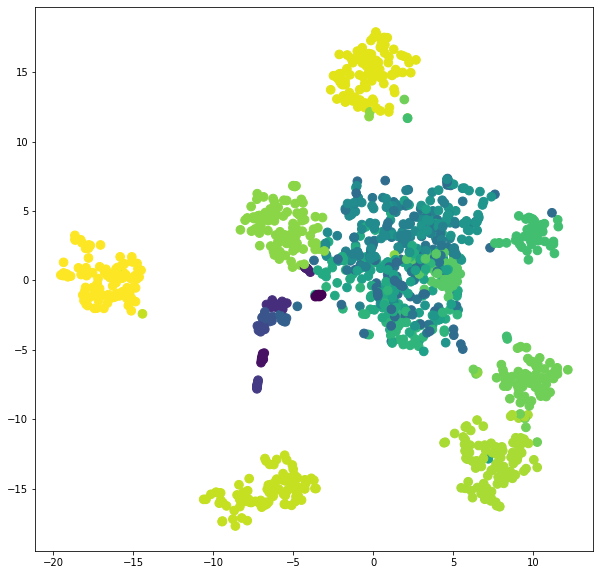

In [39]:
print("Combined Dataset")
data = np.concatenate((X1, X, X3))
labels = np.concatenate((y1, y + 8, y3+16))
print(np.unique(labels))
from sklearn.utils import shuffle
X_comp, y_comp = shuffle(data, labels, random_state = 0)

d = tsne(X_comp, y_comp)

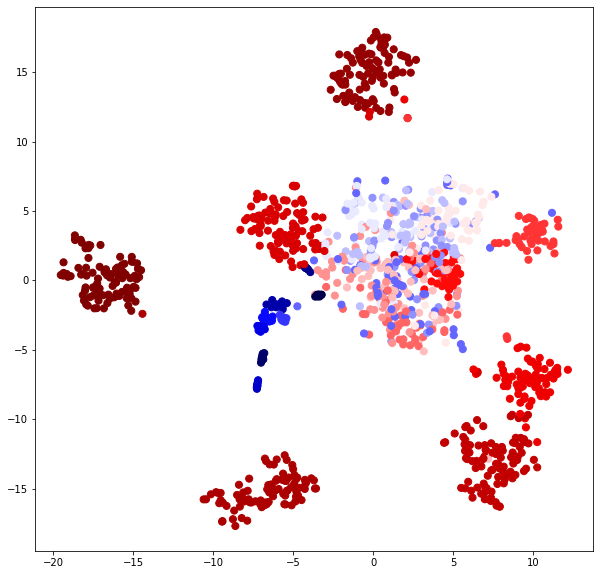

In [40]:
plt.figure(figsize=(10,10))
plt.scatter(d[:,0],d[:,1],c=y_comp, s = 50, cmap= "seismic")

#### Here, Blue is the Yale dataset, the lighter colors are the IMFDB dataset and red implies Cartoon dataset. Thus you can see the datasets cluster together and it is easy to differentiate between them. 

### Question 4
4.`face`  is  used  for  verification.   

4(a) How do we formulate the problem using KNN 

4(b) How do we analyze the performance ? suggest  the  metrics  (like  accuracy) that is appropriate for this task.

_______________________________________________________________________

4(c)Show empirical re-sults  with  all  the  representations

In [41]:
from sklearn.neighbors import KNeighborsClassifier 

class FaceVerification():
    def __init__(self):
        super(self.__class__, self).__init__()
        self.distance_threshold = 0.6
        self.model = KNeighborsClassifier(n_neighbors = 5) 

    # Define your parameters eg, W,b, max_iterations etc. 
    
    def verify(self,response,class_id):
        """
            Given an input X find if the class id is correct or not.
            
            @return verfication_results => N vector containing True or False. 
                    If the class-id matches with your prediction then true else false.   
        """
        # knn_clf = self.model
        # response = knn_clf.predict(np.array[X]) 
        verfication_results = []
        for i in range(len(class_id)):
            if response[i] == class_id[i]:
                verfication_results.append(True)
            else:
                verfication_results.append(False)
        return verfication_results
        
    def train(self,X_train,y_train, neigh = 5):
        """
            Given your training data, learn the parameters of your classifier
            
            @param X_train => NxD tensor. Where N is the number of samples and D is the dimension. 
                                it is the data on which your verification system will be trained. 
                                It can be any combination of features provided above.

            @param y_train => N vector. Ground truth label 
    
            @return Nothing
        """
        self.model = KNeighborsClassifier(n_neighbors = neigh) 
        self.model.fit(X_train, y_train)
        
    def validate(self,X_validate,y_validate, flag = True):
        """
            How good is your system on unseen data? Use the function below to calculate different metrics. 
            Based on these matrix change the hyperparmeters
            
            @param X_validate => NxD tensor. Where N is the number of samples and D is the dimension. 
                                It can be any combination of features provided above.

            @param y_validate => N vector. Ground truth label 
            
        """
        knn_clf = self.model
        # closest_distances = knn_clf.kneighbors(X_validate, n_neighbors=1)
        # are_matches = [closest_distances[0][i][0] <= self.distance_threshold for i in range(len(X_face_locations))]

        # # Predict classes and remove classifications that aren't within the threshold
        # response = [(pred, loc) if rec else ("unknown", loc) for pred, loc, rec in zip(knn_clf.predict(faces_encodings), X_face_locations, are_matches)]

        response = knn_clf.predict(np.array(X_validate))
        conf_mat = confusion_matrix(response, y_validate)

        conf = pd.DataFrame(data=conf_mat)
        conf.columns.name = 'Predicted'
        conf.index.name = 'Actual'

        accuracy_test = self.verify(response, y_validate)   
        # print(accuracy_test)
        count = np.sum(np.array(accuracy_test))
        # pred = self.classify(X_validate)
        accuracy = knn_clf.score(X_validate, y_validate) * 100
        # y_score = self.clf.decision_function(X_validate)
        metrics = precision_recall_fscore_support(y_validate, response, average='macro', labels=np.unique(response))
        precision = metrics[0]*100

        if flag:
            display(conf)
            print("--------------------------------------------")
            # Calculate Validation accuracy 
            
            print("Accuracy = {0:0.2f}%".format(accuracy))
        
            # Calculate precision and recall 
            print("Precision = {0:0.2f}".format(metrics[0]*100))
            print("Recall = {0:0.2f}".format(metrics[1]*100))
            #?????????
            # Calculate F1-score
            
            print("F1 Score = {0:0.2f}".format(metrics[2]*100))
    
        return accuracy, precision, conf
        

In [42]:
# Create a train and validation split and show your results 
print("For k = 3")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, shuffle = 'true')
model = FaceVerification()
model.train(X_train, y_train, 3)
acc, f1, conf = model.validate(X_test, y_test)

For k = 3


Predicted,0,1,2,3,4,5,6,7
Actual,,,,,,,,
0,3,0,1,0,0,0,6,3
1,0,5,3,5,0,2,0,1
2,0,1,4,0,1,0,2,2
3,0,0,0,0,0,0,0,0
4,0,0,0,0,3,0,0,1
5,0,0,0,2,0,7,0,0
6,0,1,0,0,0,1,1,1
7,0,0,0,0,0,0,1,3


--------------------------------------------
Accuracy = 43.33%
Precision = 49.59
Recall = 57.67
F1 Score = 46.91


In [43]:
print("For k = 5")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, shuffle = 'true')
model = FaceVerification()
model.train(X_train, y_train)
acc, f1, conf = model.validate(X_test, y_test)

For k = 5


Predicted,0,1,2,3,4,5,6,7
Actual,,,,,,,,
0,7,0,1,1,0,0,2,2
1,0,5,4,2,2,1,0,0
2,0,2,7,2,0,0,1,0
3,0,0,0,1,1,0,0,1
4,0,0,0,0,4,0,0,0
5,0,0,0,0,0,5,0,0
6,0,1,0,0,0,0,2,1
7,0,0,0,1,0,0,3,1


--------------------------------------------
Accuracy = 53.33%
Precision = 56.40
Recall = 52.57
F1 Score = 51.34


In [44]:
print("For k = 7")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, shuffle = 'true')
model = FaceVerification()
model.train(X_train, y_train, 7)
acc, f1, conf = model.validate(X_test, y_test)

For k = 7


Predicted,0,1,2,3,4,5,6,7
Actual,,,,,,,,
0,10,1,2,1,1,0,1,1
1,0,4,1,1,4,0,2,2
2,0,0,6,4,3,0,0,1
3,0,0,0,1,0,1,0,1
4,0,0,0,1,4,0,0,0
5,0,0,0,0,0,1,0,1
6,0,1,0,0,0,0,1,0
7,0,0,0,1,0,0,1,1


--------------------------------------------
Accuracy = 46.67%
Precision = 47.11
Recall = 45.26
F1 Score = 41.07


In [45]:
print("For k = 13")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, shuffle = 'true')
model = FaceVerification()
model.train(X_train, y_train, 13)
acc, f1, conf = model.validate(X_test, y_test)

For k = 13


Predicted,0,1,2,3,4,5,6,7
Actual,,,,,,,,
0,7,1,2,2,1,1,7,1
1,0,4,2,1,4,1,0,0
2,0,1,8,0,0,0,0,2
3,0,0,0,1,0,0,0,0
4,0,0,0,0,1,0,0,0
5,0,1,0,2,0,7,0,0
6,0,0,0,0,0,0,2,0
7,0,0,0,0,0,0,0,1


--------------------------------------------
Accuracy = 51.67%
Precision = 75.98
Recall = 47.77
F1 Score = 45.89


In [46]:
print("For k = 31")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, shuffle = 'true')
model = FaceVerification()
model.train(X_train, y_train, 31)
acc, f1, conf = model.validate(X_test, y_test)

For k = 31


Predicted,0,1,2,3,4,5,6,7
Actual,,,,,,,,
0,9,3,1,1,0,0,4,1
1,0,3,2,0,2,1,0,1
2,0,1,8,2,0,0,0,3
3,0,0,0,0,0,0,0,0
4,0,1,0,0,1,0,1,2
5,0,0,0,1,0,6,0,1
6,0,0,0,0,0,0,1,3
7,0,0,0,0,0,0,1,0


--------------------------------------------
Accuracy = 46.67%
Precision = 36.83
Recall = 49.08
F1 Score = 40.97


In [47]:
# Create 3 tables simiar to page-6 of the paper. One table per dataset 
# Each table will have 5 columns. 
# Feature/combination of feature used, reduced dimension space, verification error, accuracy, precision
import warnings

warnings.filterwarnings(action='ignore')
columns=['Method','Reduced Dim','Classification Error','Accuracy','Precision']
index=['1','2','3','4','5', '6','7','8', '9','10']
data = []

datasets = ["./dataset/Yale_face_database","./dataset/IMFDB","./dataset/IIIT-CFW"]
num_class = [15,8,8]
best = []
best_conf = []
for k in range(len(datasets)):
    Xdash, ydash = load_data(datasets[k])
    N,H,W = Xdash.shape[0:3]
    C = 1 if opt['is_grayscale'] else Xdash.shape[3]
    # og = Xdash.copy()

    Xdash = Xdash.reshape((N,H*W*C))
    feat=get_resnet_features(datasets[k])

    X_train, X_test, y_train, y_test = train_test_split(feat, ydash, test_size=0.25, random_state=42)

    model = FaceVerification()
    model.train(X_train, y_train)
    acc, fscore, _ = model.validate(X_test, y_test, False)
    data.append(['Resnet + KNN',feat.shape[1], 100 - acc, acc, fscore])


    X_train, X_test, y_train, y_test = train_test_split(Xdash, ydash, test_size=0.25, random_state=42)
    model.train(X_train, y_train, 11)
    acc, fscore, _ = model.validate(X_test, y_test, False)
    data.append(['KNN, k = 11',feat.shape[1], 100 - acc, acc, fscore])

    model.train(X_train, y_train, 43)
    acc, fscore, _ = model.validate(X_test, y_test, False)
    data.append(['KNN, k = 43',feat.shape[1], 100 - acc, acc, fscore])


    feat=get_resnet_features(datasets[k])
    feat=get_kernel_lda(feat, ydash, 7, 'sigmoid')

    X_train, X_test, y_train, y_test = train_test_split(feat, ydash, test_size=0.25, random_state=42)

    model = FaceVerification()
    model.train(X_train, y_train)
    acc, fscore, _ = model.validate(X_test, y_test, False)
    data.append(['Resnet + sigmoid KernelLDA + KNN',feat.shape[1], 100 - acc, acc, fscore])

    feat=get_resnet_features(datasets[k])
    feat=get_lda(feat, ydash, 7)

    X_train, X_test, y_train, y_test = train_test_split(feat, ydash, test_size=0.25, random_state=42)

    model.train(X_train, y_train)
    acc, fscore, _ = model.validate(X_test, y_test, False)
    data.append(['Resnet + LDA + KNN',feat.shape[1], 100 - acc, acc, fscore])

    feat = get_pca(Xdash, 100)
    X_train, X_test, y_train, y_test = train_test_split(feat, ydash, test_size=0.25, random_state=42)

    model.train(X_train, y_train)
    acc, fscore, _ = model.validate(X_test, y_test, False)
    data.append(['PCA + KNN',feat.shape[1], 100 - acc, acc, fscore])

    feat=get_resnet_features(datasets[k])
    feat=get_kernel_lda(feat, ydash, 7)

    X_train, X_test, y_train, y_test = train_test_split(feat, ydash, test_size=0.25, random_state=42)

    model = FaceVerification()
    model.train(X_train, y_train)
    acc, fscore, _ = model.validate(X_test, y_test, False)
    data.append(['Resnet + rbf KernelLDA + KNN',feat.shape[1], 100 - acc, acc, fscore])

    feat=get_vgg_features(datasets[k])
    # feat=get_kernel_lda(feat, ydash, 7)

    X_train, X_test, y_train, y_test = train_test_split(feat, ydash, test_size=0.25, random_state=42)

    model = FaceVerification()
    model.train(X_train, y_train)
    acc, fscore, _ = model.validate(X_test, y_test, False)
    data.append(['VGG + KNN, k = 5',feat.shape[1], 100 - acc, acc, fscore])

    model.train(X_train, y_train, 11)
    acc, fscore, _ = model.validate(X_test, y_test, False)
    data.append(['VGG + KNN, k = 11',feat.shape[1], 100 - acc, acc, fscore])

    feat=get_resnet_features(datasets[k])
    feat=get_kernel_lda(feat, ydash, 7, 'poly')

    X_train, X_test, y_train, y_test = train_test_split(feat, ydash, test_size=0.25, random_state=42)
    model.train(X_train, y_train)
    acc, fscore, _ = model.validate(X_test, y_test, False)
    data.append(['poly KernelLDA + KNN',feat.shape[1], 100 - acc, acc, fscore])


best = np.asarray(best)
best_conf = np.asarray(best_conf)

df1 = pd.DataFrame(data[0:10],columns=columns, index=index)
print("\nTable for Yale_face_database")
display(df1)

# Print the table. (You can use Pandas)

# Print the table. (You can use Pandas)

Dataset shape: (165, 64, 64)
Dataset shape: (400, 64, 64)
Dataset shape: (672, 64, 64)

Table for Yale_face_database


,Method,Reduced Dim,Classification Error,Accuracy,Precision
1,Resnet + KNN,2048,0.000000,100.000000,100.000000
2,"KNN, k = 11",2048,28.571429,71.428571,73.214286
3,"KNN, k = 43",2048,78.571429,21.428571,32.511905
4,Resnet + sigmoid KernelLDA + KNN,7,0.000000,100.000000,100.000000
5,Resnet + LDA + KNN,7,0.000000,100.000000,100.000000
6,PCA + KNN,100,23.809524,76.190476,80.555556
7,Resnet + rbf KernelLDA + KNN,7,0.000000,100.000000,100.000000
8,"VGG + KNN, k = 5",4096,47.619048,52.380952,59.230769
9,"VGG + KNN, k = 11",4096,66.666667,33.333333,44.583333
10,poly KernelLDA + KNN,7,0.000000,100.000000,100.000000


In [48]:
df2 = pd.DataFrame(data[10:20],columns=columns, index=index)
print("\nTable for IMFDB")
display(df2)


Table for IMFDB


,Method,Reduced Dim,Classification Error,Accuracy,Precision
1,Resnet + KNN,2048,4.0,96.0,95.833333
2,"KNN, k = 11",2048,61.0,39.0,53.879270
3,"KNN, k = 43",2048,68.0,32.0,29.336363
4,Resnet + sigmoid KernelLDA + KNN,7,0.0,100.0,100.000000
5,Resnet + LDA + KNN,7,0.0,100.0,100.000000
6,PCA + KNN,100,57.0,43.0,52.492709
7,Resnet + rbf KernelLDA + KNN,7,0.0,100.0,100.000000
8,"VGG + KNN, k = 5",4096,9.0,91.0,90.623283
9,"VGG + KNN, k = 11",4096,5.0,95.0,95.757212
10,poly KernelLDA + KNN,7,0.0,100.0,100.000000


In [49]:
df3 = pd.DataFrame(data[20:30],columns=columns, index=index)
print("\nTable for IIIT_Cartoon")
display(df3)


Table for IIIT_Cartoon


,Method,Reduced Dim,Classification Error,Accuracy,Precision
1,Resnet + KNN,2048,2.380952,97.619048,97.865172
2,"KNN, k = 11",2048,65.476190,34.523810,44.234165
3,"KNN, k = 43",2048,62.500000,37.500000,53.055907
4,Resnet + sigmoid KernelLDA + KNN,7,0.000000,100.000000,100.000000
5,Resnet + LDA + KNN,7,0.000000,100.000000,100.000000
6,PCA + KNN,100,61.904762,38.095238,41.739258
7,Resnet + rbf KernelLDA + KNN,7,0.000000,100.000000,100.000000
8,"VGG + KNN, k = 5",4096,33.928571,66.071429,64.281290
9,"VGG + KNN, k = 11",4096,33.333333,66.666667,65.117696
10,poly KernelLDA + KNN,7,0.000000,100.000000,100.000000


### Extenstion / Application
    Create a system for any one of the following problems:

- Politicians  vs  Filmstars  in  a  public  data  set.   (eg.LFW)
        You already have seen IIIT-CFW dataset. Use it for classification. 
- Age prediction
        Given different actors/actress in IMFDB create new labels based on their age.  
- Gender prediction
        Given different actors/actress in IMFDB+IIIT-CFW create new labels based on their gender.
- Emotion classification
        Both the yale dataset and IMFDB contain an `emotion.txt` file. Using that you can create a emotion predicter 
- cartoon vs real images
        Use a combination of IIIT-CFW and other dataset. 
        


You are free to use a new dataset that is publicly available or even create one by crawling from internet.

In [50]:
# Load data
cfw_dict_modified = {'Amitabhbachan': 0,
    'AamirKhan': 0,
    'DwayneJohnson': 0,
    'AishwaryaRai': 0,
    'BarackObama': 1,
    'NarendraModi': 1,
    'ManmohanSingh': 1,
    'VladimirPutin': 1}

def modified_load_data(dir_path):
    image_list = []
    y_list = []
    
    if "CFW" in dir_path:
        label_dict = cfw_dict_modified   
    
    for filename in sorted(os.listdir(dir_path)):
        if filename.endswith(".png"):
            im = load_image(os.path.join(dir_path,filename))
            y = filename.split('_')[0]
            y = label_dict[y] 
            image_list.append(im)
            y_list.append(y)
        else:
            continue

    image_list = np.array(image_list)
    y_list = np.array(y_list)

    print("Dataset shape:",image_list.shape)

    return image_list,y_list
X,y=modified_load_data('./dataset/IIIT-CFW')
# print(Y)
# print(X.shape)
X=X.reshape((672,64*64)) ##flattening the data
print(X.shape)

Dataset shape: (672, 64, 64)
(672, 4096)


349


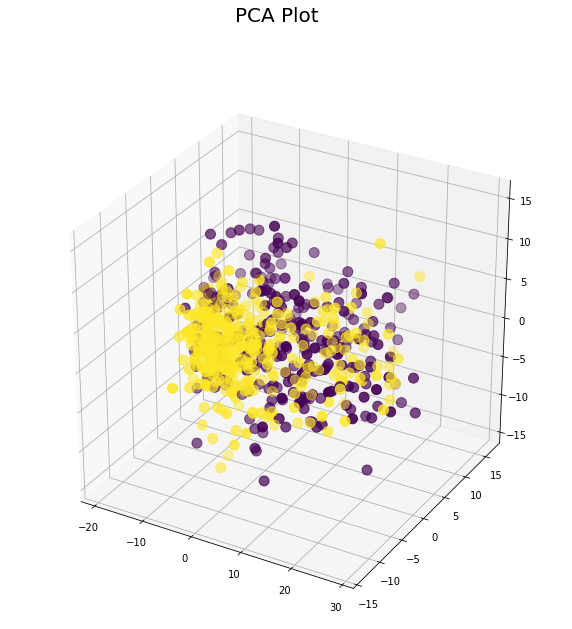

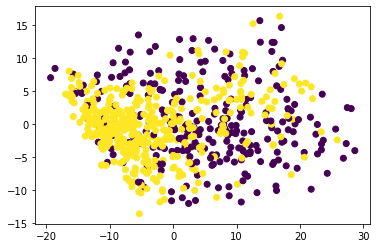

In [51]:
# Define your features
# feat=get_resnet_features('./dataset/IIIT-CFW')
# feat = get_lda(resnetd,y,100)
pca = PCA(n_components=len(y))
pca.fit(X)

a = np.asarray(pca.explained_variance_ratio_)
req_pc = (np.cumsum(a)<=0.95).argmin()
# req_pc = pc(eig_vals, eig_vals_Sum)
print(req_pc)
pca1 = PCA(n_components=req_pc)
feat = pca1.fit_transform(X,y)



fig = plt.figure(figsize=(10,10))
fig.suptitle('PCA Plot', fontsize=20)
ax = fig.add_subplot(111, projection='3d')
ax.scatter(feat[:,0],feat[:,1],feat[:,2],c=y, s = 100)

fig = plt.figure()
plt.scatter(feat[:,0],feat[:,1], c = y)

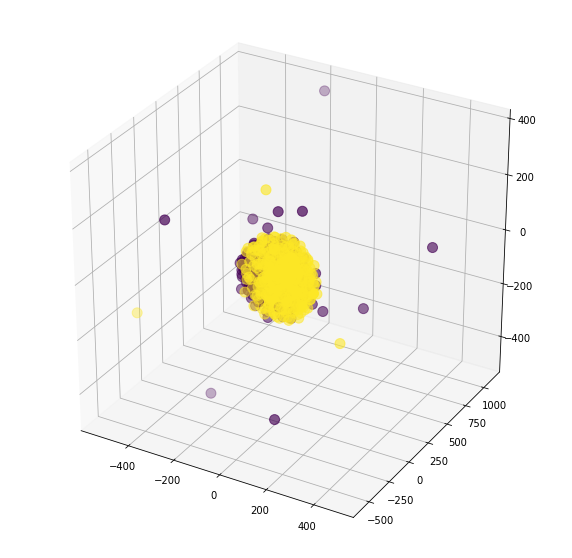

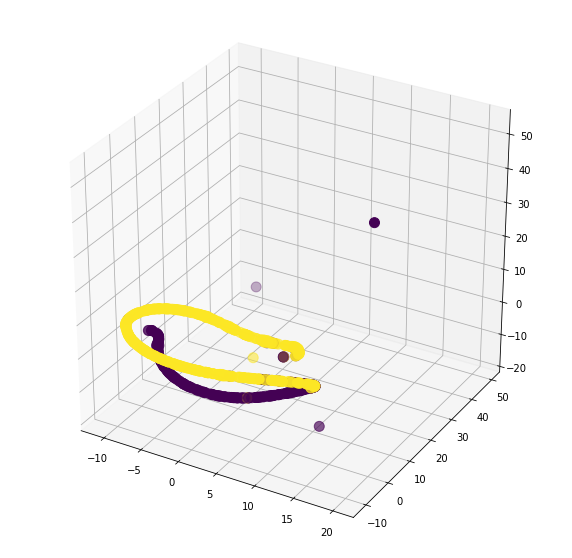

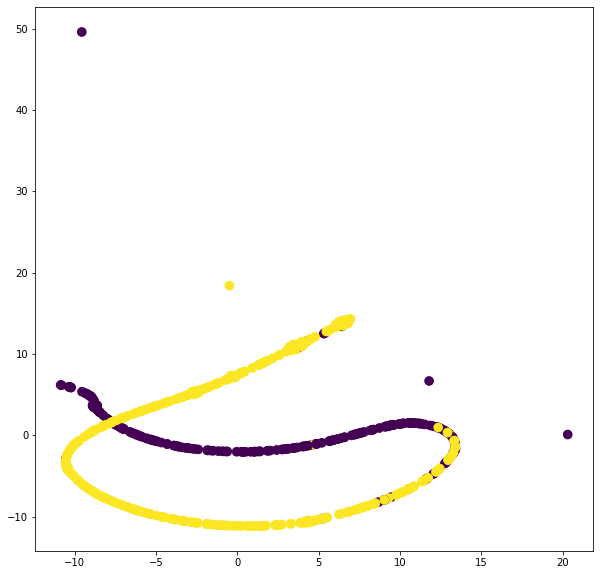

In [52]:
feat = tsne(X, y)

(672, 2048)


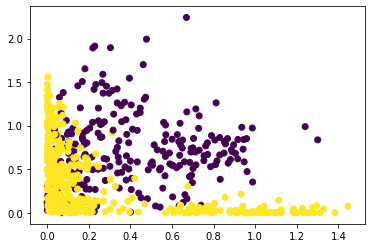

In [53]:
# After lDA
feat = get_resnet_features('./dataset/IIIT-CFW')
print(feat.shape)
fig = plt.figure()
plt.scatter(feat[:,0],feat[:,1], c = y)

In [57]:
# Create your classifier
X_train, X_test, y_train, y_test, _, test_indices = train_test_split(feat, y, np.arange(len(y)), test_size=0.25, shuffle='true')
classifier=MLPClassifier(hidden_layer_sizes=(200,50),max_iter=1000)
clf=classifier.fit(X_train,y_train)
# Validate your classifier
results=clf.predict(X_test)



In [58]:
# Show qualitative results such as accuracy, k-fold validation, TSNE/PCA/Isomap plots, etc.
model = Classifier()
conf_mat, pdframe = model.confusion_matrix(results, y_test)
accuracy = clf.score(X_test, y_test) * 100
# y_score = self.clf.decision_function(X_validate)
metrics = precision_recall_fscore_support(y_test, results, average='macro', labels=np.unique(results))
f1score = metrics[2]*100
print(accuracy)
display(pdframe)

97.61904761904762


Predicted,0,1
Actual,,
0,77,1
1,3,87


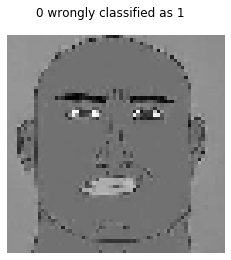

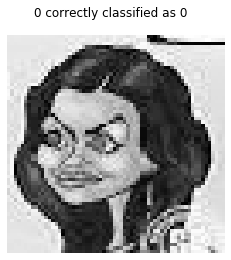

In [59]:
# Show quantitative results such as examples of correct prediction and wrong prediction
wrong_image = None
right_image = None
for i in range(len(y_test)):
    if results[i] != y_test[i]:
        wrong_image = i
    else:
        right_image = i
    if wrong_image is not None and right_image is not None:
        break
reconstruct_images = X[test_indices[wrong_image]].reshape((64,64))
# ind = np.random.randint(0,y3.shape[0],6)
fig1 = plt.figure()
fig1.suptitle(str(y_test[wrong_image]) + " wrongly classified as " + str(results[wrong_image]))
# print(str(y_test[wrong_image]) + " wrongly classified as " + str(results[wrong_image]))
plt.axis("off")
plt.imshow(reconstruct_images, cmap="gray")

reconstruct_images = X[test_indices[right_image]].reshape((64,64))
# ind = np.random.randint(0,y3.shape[0],6)
fig = plt.figure()
fig.suptitle(str(y_test[right_image]) + " correctly classified as " + str(results[right_image]))
plt.axis("off")
plt.imshow(reconstruct_images, cmap="gray")